In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('science')

# Folder directory for the figures of this notebook
figure_folder = r'C:/Users/noedi/Desktop/lab_optique/data/fibre_optique/' # à changer selon la personne 

## Semaine 1:
Objectifs de la semaine; 
- Caractérisation de la fibre multimode (ouverture numérique, V, nombre de modes)
- Caractérisation des deux fibres monomodes (ouverture numérique, V, nombre de modes).

On commence par la fibre multimode. Juste pour voir un peu mieux la photo du patron avec la fibre multimode, essayons de la mettre en espace logarithmique


In [2]:
image = plt.imread(figure_folder + "/check.jpg")
image.shape

(1536, 2048, 3)

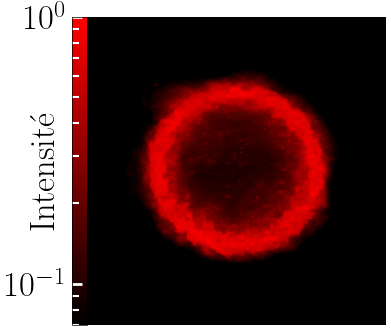

In [3]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(1, 1, figsize = (14, 4))
extent = 600
height, width, _ = image.shape
D = (height - extent+200)//2
U = (height + extent+200)//2
D_2 = (width - extent)//2
U_2 = (width + extent)//2


# Merci Stack Overflow (https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors)!
colors = [(0, 0, 0), (1, 0, 0)] 
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)

norm = LogNorm(vmin = 7e-2, vmax = 1, clip = True)
# norm=None
im = axs.imshow(image[D:U, D_2:U_2, 0] / image.max(), origin = "lower", cmap = cm, norm = norm) 
axs.axis("off")
# axs.annotate(r'$R$',xy=(0.5,0.52),xytext=(0.8,0.5), arrowprops={'arrowstyle': '<->', 'color': 'white'}, xycoords = 'axes fraction', color = "white", weight = 'bold')

cbar = plt.colorbar(im, fraction = 0.04, pad = -0.29)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.set_label("Intensité", labelpad = -40)
cbar.ax.tick_params(which = 'major', length = 7, width = 2, color = 'white')
cbar.ax.tick_params(which = 'minor', length = 5, width = 1.5, color = 'white')
# plt.savefig(figure_folder + 'photo_multimode_annotated.pdf', bbox_inches = 'tight')
plt.savefig(figure_folder + 'photo_multimode_no_annotate.pdf', bbox_inches = 'tight')

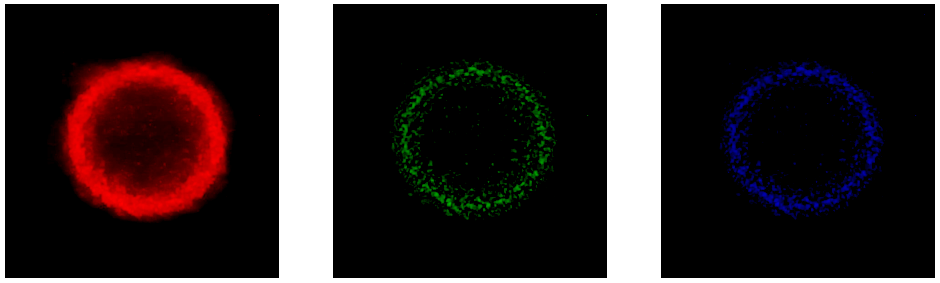

In [4]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
extent = 600
height, width, _ = image.shape
D = (height - extent+200)//2
U = (height + extent+200)//2
D_2 = (width - extent)//2
U_2 = (width + extent)//2


# Merci Stack Overflow (https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors)!
colors = [(0, 0, 0), (1, 0, 0)] 
cm = LinearSegmentedColormap.from_list(
        "R", colors, N=100)
colors = [(0, 0, 0), (0, 1, 0)] 
cm1 = LinearSegmentedColormap.from_list(
        "G", colors, N=100)
colors = [(0, 0, 0), (0, 0, 1)] 
cm2 = LinearSegmentedColormap.from_list(
        "B", colors, N=100)
norm = LogNorm(vmin = 7e-2, vmax = 1, clip = True)
cms = [cm, cm1, cm2]
# norm=None
for i, ax in enumerate(axs):
        im = ax.imshow(image[D:U, D_2:U_2, i] / image[:, :, i].max(), origin = "lower", cmap = cms[i], norm = norm) 
        ax.axis("off")

On a réussi à créer du vert et du bleu avec un laser bleu :/ (portable bizarre?). 

### Fibre multimode
Notre premier objectif est de faire une régression linéaire pour les valeurs distance vs diamètre pour le patron vu sur l'écran. Définissons notre modèle linéaire comme suit: 
$$
y = \beta_0 + \beta_1 x \qquad \text{avec} \quad \begin{cases} y\equiv \text{Rayon du patron} \\  x\equiv\text{Distance de l'écran}\end{cases}
$$


In [5]:
# Importing the data
fname = figure_folder + r"multimode_mesures.txt"
data = np.loadtxt(fname, skiprows=1)
radius, distance = data[:, 0]/2, data[:, 1] # cm
sigma_radius, sigma_distance = 1e-1, 1e-1 # cm la demi-mesure la plus petite de la règle

# Définissons y et x pour la régression
x = distance 
y = radius 
sigma_x = sigma_distance
sigma_y = sigma_radius

Text(0, 0.5, 'Rayon [cm]')

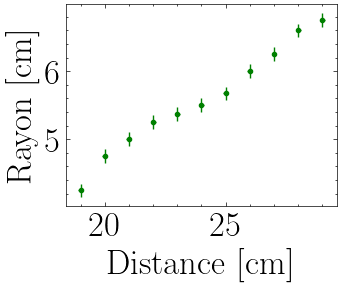

In [6]:
# Analyse préliminaire des données (sanity check)
plt.errorbar(distance, radius,  xerr = sigma_radius, yerr = sigma_distance, fmt = ".", color = "green")
plt.xlabel("Distance [cm]")
plt.ylabel("Rayon [cm]")

In [7]:
Regression_multimode = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y
)


params_fitted, std_fitted = Regression_multimode.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = True
)

y_pred = Regression_multimode.forward_model()
cov = Regression_multimode.cov
chi2 = Regression_multimode.compute_chi2(obs = y)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2)

The parameters fitted are [0.02909091 0.23136364]
The std of the params fitted are [0.23080885 0.00953463]
The cov of the params fitted is [[ 5.32727273e-02 -2.18181818e-03]
 [-2.18181818e-03  9.09090909e-05]]
The chi squared is: 1.187878787878784


Très bien, on a fait la régression, maintenant propageons les incertitudes sur les paramètres de régression dans notre modèle physique (i.e. notre modèle linéaire de régression ici). On a 
$$
\sigma_y = \sqrt{\sigma_{\beta_0}^2 + \sigma_{\beta_1}^2x^2 + \sigma_x^2 \beta_1^2}
$$

In [8]:
def model(x, params_fitted): 
    return params_fitted[0] + params_fitted[1] * x

def std_model(x, sigma_x, params_fitted, std_fitted):
    beta_0, beta_1 = params_fitted 
    std_beta0, std_beta1 = std_fitted 
    return np.sqrt(std_beta0 ** 2 + std_beta1 ** 2 * x **2 + sigma_x ** 2 * beta_1 ** 2) 


In [9]:
sigma_reg = std_model(x, sigma_x, params_fitted, std_fitted)
sigma_reg

array([0.29432329, 0.30028596, 0.30642932, 0.31274274, 0.31921611,
       0.32583992, 0.33260517, 0.33950341, 0.34652669, 0.35366756,
       0.36091905])

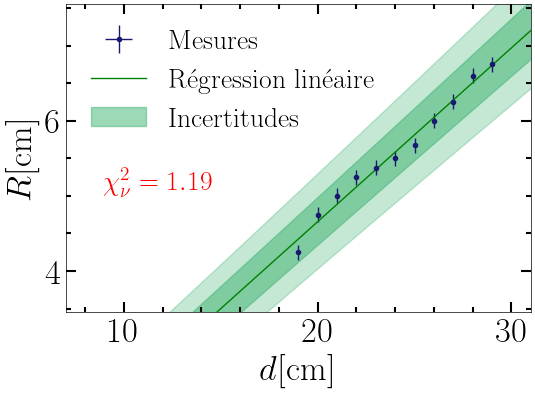

In [10]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs
x_fill = np.linspace(0, 50, 1000)
y_pred = model(x_fill, params_fitted) # prédiction du modèle de régression linéaire
std_reg = std_model(x_fill, sigma_x, params_fitted, std_fitted)
std_tot = np.sqrt(std_reg ** 2 + sigma_y ** 2)

# Mettre mesures et régression linéaire 
ax.errorbar(distance, radius,  xerr = sigma_radius, yerr = sigma_distance, fmt = ".", color = "midnightblue", label = "Mesures")
ax.plot(x_fill, y_pred, color = "green", label = "Régression linéaire")

# Première zone d'incertitude
k = 1
ax.fill_between(
    x = x_fill, 
    y1=y_pred - k * std_tot, 
    y2 = y_pred + k * std_tot, 
    color = "mediumseagreen",
    label = "Incertitudes", 
    alpha  = 0.5
)

k = 2
ax.fill_between(
    x = x_fill, 
    y1=y_pred - k * std_tot, 
    y2 = y_pred + k * std_tot, 
    color = "mediumseagreen",
    alpha  = 0.3
)

extent_x = 2
extent_y = 0.8
ax.set(xlim = [x.min()-extent_x - 10, x.max() + extent_x], ylim = [y.min() - extent_y, y.max() + extent_y], xlabel = r"$d$[cm]", ylabel = r"$R$[cm]")
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.08, 0.4), xycoords = "axes fraction", color = "red", fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])
# ax.legend()
plt.savefig(figure_folder + "multimode_regression.pdf", bbox_inches = 'tight')

Propagation des incertitudes pour la fibre multimode: 

J'ignore ici l'ordonnée à l'origine puisqu'elle est à 1 ordre de grandeur en dessous... 
$$
NA = \sin\left( \arctan\left(\frac{R}{d}\right)\right)= \frac{R}{d\sqrt{\frac{R^2}{d^2}+1}}=\frac{R}{\sqrt{R^2 + d^2 }} = \frac{\beta_1}{\sqrt{\beta_1^2 + 1}}
$$
L'incertitude sur l'ouverture numérique est 
$$
\sigma_{NA} = \frac{\sigma_{\beta_1}}{(\beta_1^2 + 1)^{3/2}} =^{?} /frac{d}{\sqrt{\frac{R^2}{d^2}}}
$$

In [11]:
_, slope = params_fitted 
_, std_slope = std_fitted
na_exp = np.sin(np.arctan(slope))
print(na_exp)
# OU 
na_exp = slope / (np.sqrt(slope ** 2 + 1))
print(na_exp)

std_na = std_slope  / (slope**2 + 1) ** (3 / 2)

na_theo = 0.22
print(f"Ouverture numérique théorique égale à {na_theo:.2f}")  
print(f"Ouverture numérique expérimentale égale à {na_exp.item():.2f} +/- {std_na.item():.2f}")

0.22540929822077693
0.2254092982207769
Ouverture numérique théorique égale à 0.22
Ouverture numérique expérimentale égale à 0.23 +/- 0.01


On a perdu un 3 (holy molly). Calculons maintenant le nombre d'onde normalisé $V$

$$
V = \frac{2\pi a \times \text{NA}}{\lambda}
$$

Pour la fibre multimode, les valeurs de $a$ et de $\lambda$ sont connues (on va assumer que l'incertitude est négligeable par rapport à celle de l'ouverture numérique). Donc, on a seulement besoin de propager l'incertitude expérimentale liée à l'ouverture numérique, on obtient simplement 
$$
\sigma_{V} = \frac{2\pi a \times \sigma_\text{NA}}{\lambda}
$$

In [12]:
def compute_V(radius, numerical_aperture, wavelength=632.8 * 1e-9):
    return 2 * np.pi * radius * numerical_aperture / wavelength


a = 52.5 * 1e-6 # m
red_lambda = 632.8 * 1e-9 # m
V_theo = compute_V(radius = a, numerical_aperture = na_theo, wavelength = red_lambda)
V_exp = compute_V(radius = a, numerical_aperture = na_exp, wavelength = red_lambda)
std_V = compute_V(radius = a, numerical_aperture = std_na, wavelength = red_lambda)
print(f"Le nombre d'onde normalisé théorique est {V_theo:.3g}")
print(f"Le nombre d'onde normalisé expérimental est {V_exp:.3g} +/- {std_V:.0f}")

Le nombre d'onde normalisé théorique est 115
Le nombre d'onde normalisé expérimental est 118 +/- 5


Finalement, le nombre de mode peut être calculé comme (pour les deux directions de polarisations, perpendiculaires à l'axe de la fibre optique)
$$
N_{mode} \approx \frac{V^2}{2}
$$



In [13]:
def compute_N(V):
    return V ** 2 / 2

def compute_std_N(V, std_V):
    return 2 * V * std_V

N_theo = compute_N(V_theo)
N_exp = compute_N(V_exp)
std_N = compute_std_N(V_exp, std_V)
print(f"Le nombre de modes théorique est {int(N_theo):.2g}")
print(f"Le nombre de modes expérimental est {int(N_exp):.2g} +/- {std_N:.2g}")

Le nombre de modes théorique est 6.6e+03
Le nombre de modes expérimental est 6.9e+03 +/- 1.1e+03


Préparation pour la semaine 2: 
Avant de passer aux mesures sur les fibres monomodes, commençons par calculer les différentes valeurs possibles théoriques de nombre d'onde normalisé pour chaque fibre monomode

In [14]:
class Fiber: 
    def __init__(self, name, radius, numerical_aperture):
        self.radius = radius # rayon du coeur (meters)
        self.numerical_aperture = numerical_aperture # ouverture numérique (sans unité)
        self.name = name

    def compute_V(self, wavelength): 
        return 2 * np.pi * self.radius * self.numerical_aperture / wavelength
    
    def compute_N(self, wavelength):
        V = self.compute_V(wavelength)
        return V ** 2 / 2

    def compute_std_N(self, wavelength, std_V):
        V = self.compute_V(wavelength)
        return 2 * V * std_V
    
    def print_properties(self): 
        print(f'Rayon du coeur vaut: {self.radius * 1e6:.3g} micro-mètres')
        print(f'Ouverture numérique vaut: {self.numerical_aperture:.2g}')

    def print_wavelength_properties(self, wavelength):
        print(f"Nombre d'onde normalisé vaut: {self.compute_V(wavelength):.2g}")
        print(f"Nombre de modes {self.compute_N(wavelength):.2g}")

In [15]:
if np.ones(1): 
    print("hey")

hey


In [16]:
fiber1 = Fiber(name = "Fiber 1", radius = 1.75 * 1e-6, numerical_aperture=0.13)
fiber2 = Fiber(name = "Fiber 2", radius = 2.2 * 1e-6,  numerical_aperture=0.13)
fiber3 = Fiber(name = "Fiber 3", radius = 1.8 * 1e-6,  numerical_aperture=0.2)

wavelengths = {"red": 632.8 * u.nanometer, "green": 532 * u.nanometer, "blue": 402.5* u.nanometer}
fibers = [fiber1, fiber2, fiber3]

for fiber in fibers:
    print(f'PROPERTIES FOR FIBER MONOMODE {fiber.name}') 
    fiber.print_properties()
    for color in list(wavelengths.keys()):
        print(f"Laser {color}")
        fiber.print_wavelength_properties(wavelengths[color].to(u.meter).value)
        print()
    print()
    print()

PROPERTIES FOR FIBER MONOMODE Fiber 1
Rayon du coeur vaut: 1.75 micro-mètres
Ouverture numérique vaut: 0.13
Laser red
Nombre d'onde normalisé vaut: 2.3
Nombre de modes 2.6

Laser green
Nombre d'onde normalisé vaut: 2.7
Nombre de modes 3.6

Laser blue
Nombre d'onde normalisé vaut: 3.6
Nombre de modes 6.3



PROPERTIES FOR FIBER MONOMODE Fiber 2
Rayon du coeur vaut: 2.2 micro-mètres
Ouverture numérique vaut: 0.13
Laser red
Nombre d'onde normalisé vaut: 2.8
Nombre de modes 4

Laser green
Nombre d'onde normalisé vaut: 3.4
Nombre de modes 5.7

Laser blue
Nombre d'onde normalisé vaut: 4.5
Nombre de modes 10



PROPERTIES FOR FIBER MONOMODE Fiber 3
Rayon du coeur vaut: 1.8 micro-mètres
Ouverture numérique vaut: 0.2
Laser red
Nombre d'onde normalisé vaut: 3.6
Nombre de modes 6.4

Laser green
Nombre d'onde normalisé vaut: 4.3
Nombre de modes 9

Laser blue
Nombre d'onde normalisé vaut: 5.6
Nombre de modes 16





## Semaine 2
On commence par un peu de théorie de propagation des modes pour la fibre optique. Je me fie à deux sources principales:
- [Ce site web](https://www.rp-photonics.com/lp_modes.html); 
- Le livre _Spatial Optical-Fiber Coupling Technology in Optical-Wireless Communication_ de Xizheng Ke.

On va étudier théoriquement l'aspect du champ électrique à un temps $t$ fixe et en prenant une section (imaginaire) de la fibre optique. Pour simplifier grandement les choses, on se place dans un système de coordonnées cylindriques et on place notre axe des $z$ comme étant l'axe au centre du cylindre que forme la fibre optique. 

Trouver le champ électrique $\mathbf{E}(r,\phi)$ (j'ignore ici les variables $z$ et $t$ puisqu'on les maintient fixes) revient à résoudre l'équation de Helmholtz (qui peut être dérivée des équations de Maxwell dans la matière)
$$
\nabla^2 \mathbf{E} + k^2 \mathbf{E} = 0\, .
$$

L'équation de Helmoltz est un cas spécifique du problème de Sturm-Liouville qui peut être solutionné en coordonnées cylindriques analytiquement. En première approximation, on peut assumer que la composante $z$ du champ électrique est nulle et on peut solutionner pour un champ scalaire $\Psi(r, \phi)$. 
$$
E_{z} = \cos(l\phi)\begin{cases} J_{l}(u_{lm}\frac{r}{r_{coeur}})& \quad r<r_{coeur} \\ K_{l}(w_{lm}\frac{r}{r_{coeur}}) & \quad r>r_{coeur}\end{cases}
$$
où
- $J_{lm}$ correspond à la fonction de Bessel de première espèce
- $K_{lm}$ correspond à la fonction de _Bessel modifiée_ de second espèce.
- $u_{lm}$ et $w_{lm}$ sont les -mièmes racines des deux fonctions mentionnées précédemment. Physiquement, ces racines sont déterminées par les relations suivantes
$$
\begin{align}
u_{lm} = r_{coeur}\sqrt{n_{coeur}^2k^2 - \beta^2}
\end{align}
$$
Par conséquent, les relations entre les différentes caractéristiques de la fibre vont déterminer le couple $(l,m)$ pour le mode LP. Changer l'alignement va revenir à changer l'équation ci-dessous. Dans notre cas, on veut avoir $(u_{01}, w_{01})$ pour les fibres monomodes. 

Faisons tout d'abord des figures des fonctions de Bessel qui sont introduites ci-dessus.


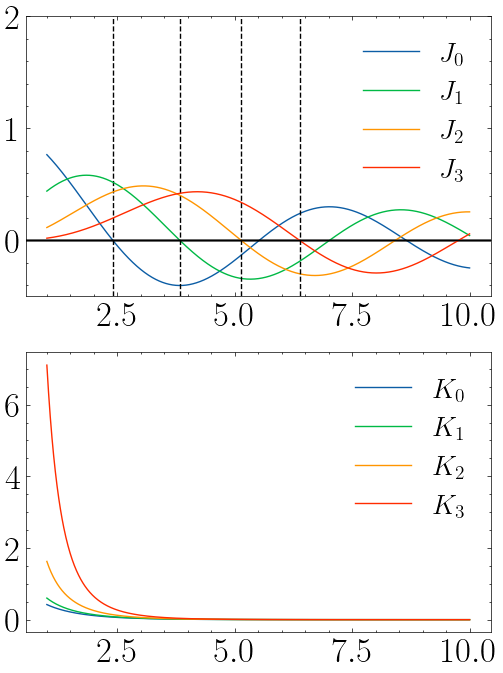

In [17]:
from scipy.special import jv, jn_zeros, kn # Bessel function and its roots

ls = np.arange(0, 4)
x = np.linspace(1, 10, 1000)
fig, axs = plt.subplots(2, 1, figsize = (6, 8))


for l in ls: 
    axs[0].plot(x, jv(l, x), label = r"$J_{%d}$"%l)
    axs[0].axvline(jn_zeros(l, 1)[0], color = 'k', ls = 'dashed')
    axs[0].axhline(0, color = 'k')
    axs[0].set(ylim = [-0.5, 2])
    axs[0].legend()
    axs[1].plot(x, kn(l, x), label = r"$K_{%d}$"%l)
    axs[1].legend()

In [18]:
jn_zeros(0, 1)

array([2.40482556])

Parfait. On remarque que la fonction de Bessel modifié tend vers 0 très rapidement; ceci est normal puisqu'on se trouve dans la gaine de la fibre optique, là où l'onde est censé être parfaitement réfléchie ! On a ce qu'on appelle une onde évanescente en mécanique quantique. Pour le reste de l'analyse, on va simplement assumer que notre seconde condition est 0 pour $r>r_{coeur}$. 

Créons maintenant le code pour afficher sur une grille de pixels la composante $E_z$ du champ électrique. Ça va nous demander de faire un meshgrid et de calculer $E_z$ pour chaque valeur de la grille. 

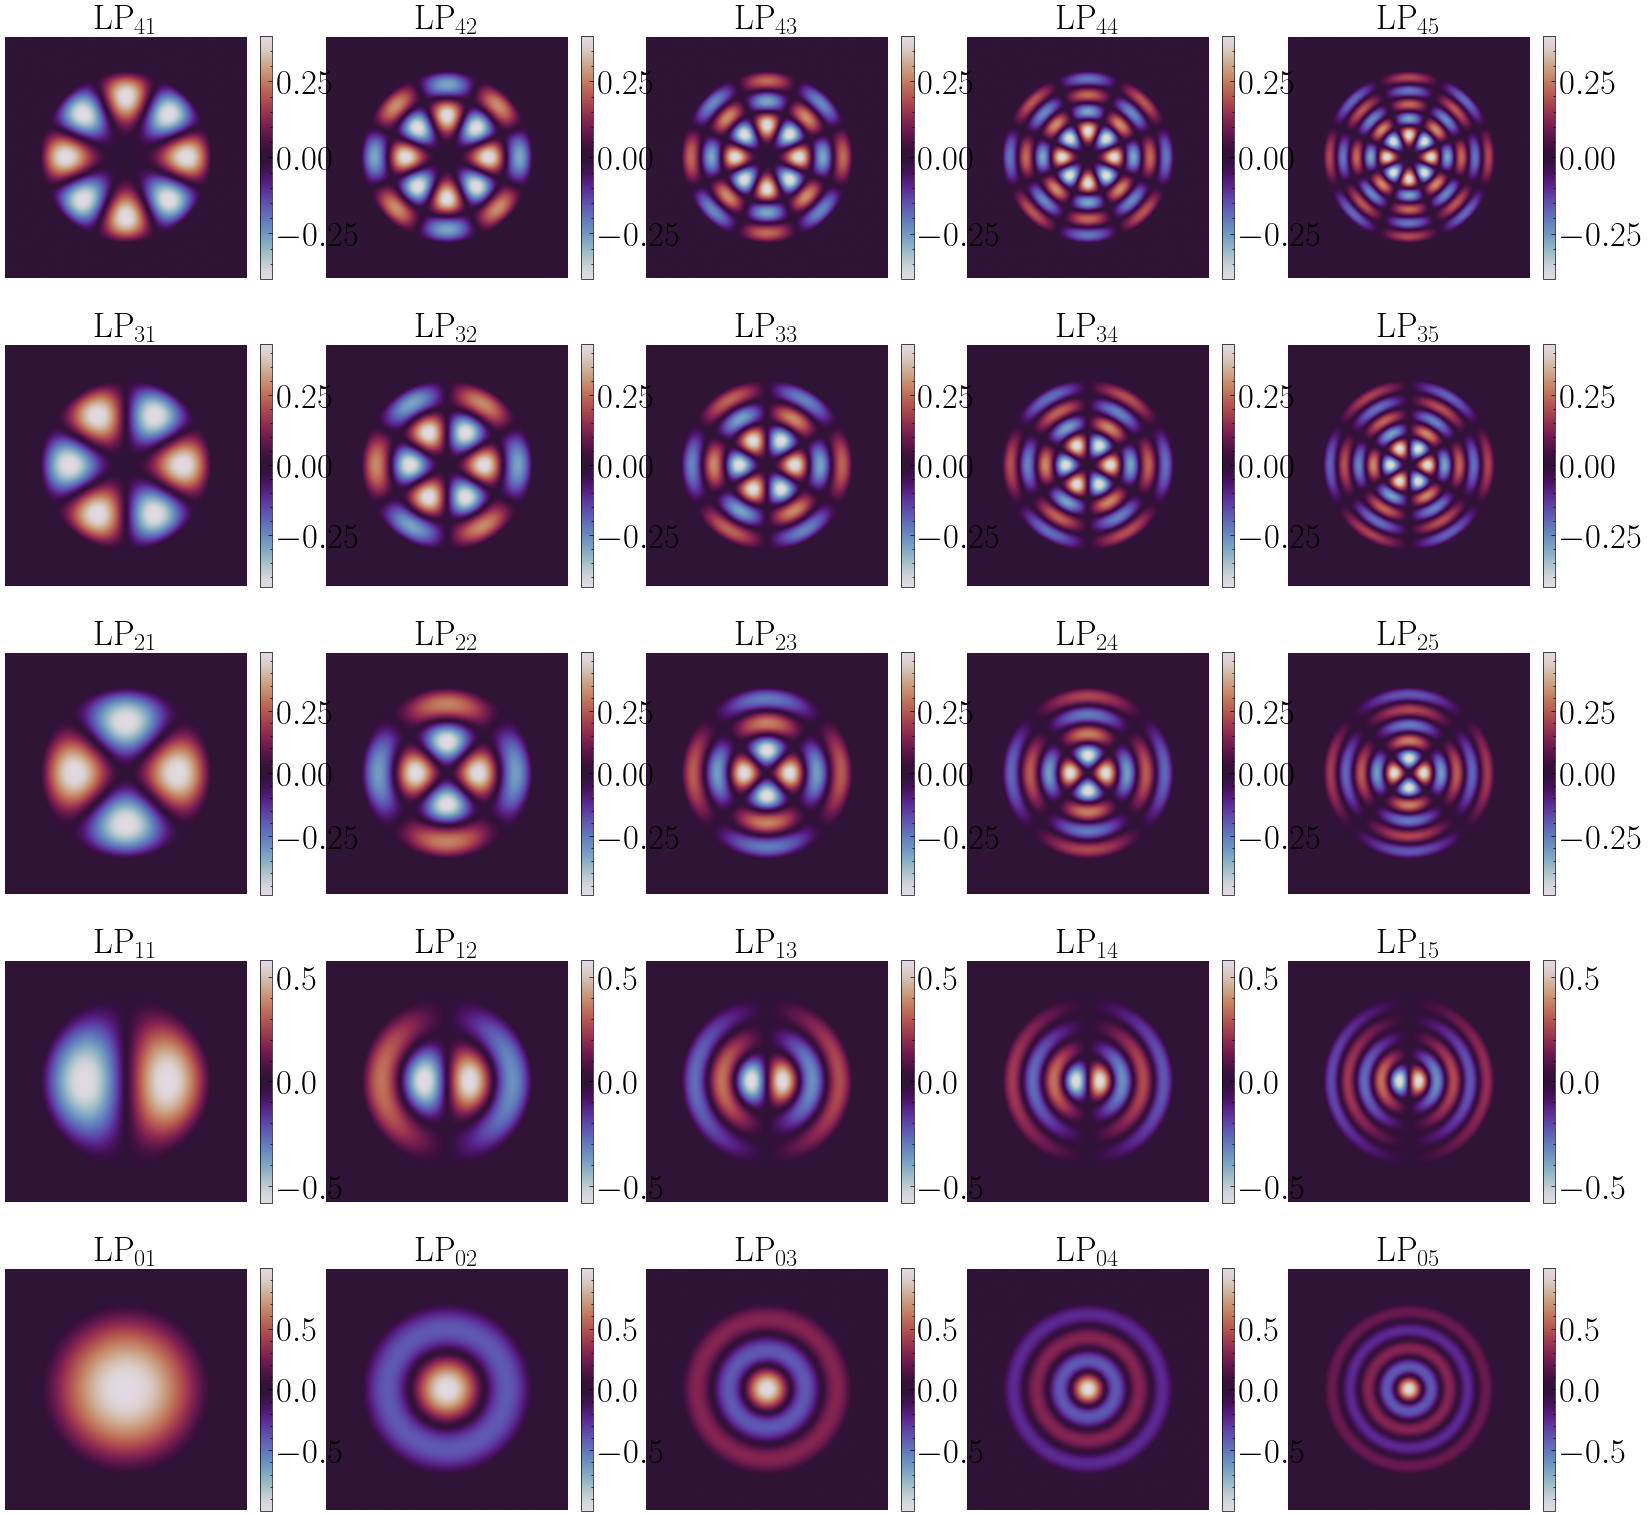

In [43]:
grid_size = 512 
r_max = 0.5 # micro mètres  
extent = 1.4 * r_max
x = np.linspace(-extent, extent, grid_size)
y = np.linspace(-extent, extent, grid_size)
X, Y = np.meshgrid(x, y)

R = np.sqrt(X**2 + Y**2)
PHI = np.arctan2(Y, X)

def lp_mode(l, m, R, PHI, r_max):
    roots = jn_zeros(l, m) 
    u_lm = roots[m-1]  # m-1 à cause du zero-indexing
    return jv(l, u_lm * R / r_max) * np.cos(l * PHI) * (R <= r_max) # la dernière multiplication mets à 0 les rayons supérieures au rayon de coeur. 

nrows, ncols = 5, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

ax = ax[::-1, :]
for l in range(nrows):
    for m in range(1, ncols+1):
        mode_field = lp_mode(l, m, R, PHI, r_max)
        
        intensity = mode_field ** 2
        norm = LogNorm(vmin = 1e-3, vmax =intensity.max(), clip = True)
        norm = None
        im = ax[l, m-1].imshow(mode_field, extent=(-r_max, r_max, -r_max, r_max), origin='lower', cmap='twilight', vmin = -abs(mode_field.max()), vmax = abs(mode_field.max()))
        plt.colorbar(im, fraction = 0.0455)
        ax[l, m-1].set_title(r"$\mathrm{LP}_{%d %d}$"%(l,m))
        ax[l, m-1].set_xlabel('x (arbitrary units)')
        ax[l, m-1].set_ylabel('y (arbitrary units)')
        ax[l, m-1].axis("off")

plt.subplots_adjust(wspace = 0.2, hspace = 0.)
# plt.savefig("LP_lm_modes.pdf", bbox_inches = 'tight')


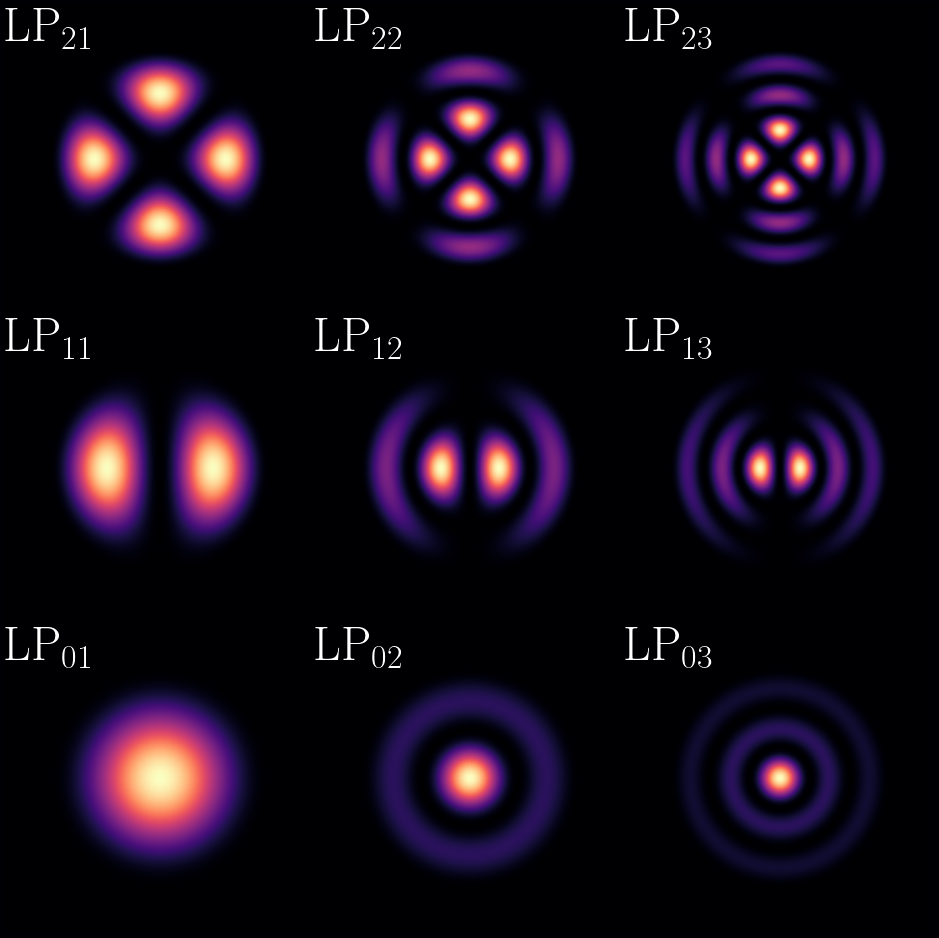

In [47]:
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4.02))

ax = ax[::-1, :]
for l in range(nrows):
    for m in range(1, ncols+1):
        mode_field = lp_mode(l, m, R, PHI, r_max)
        
        intensity = mode_field ** 2
        norm = LogNorm(vmin = 1e-3, vmax =intensity.max(), clip = True)
        norm = None
        im = ax[l, m-1].imshow(intensity, extent=(-r_max, r_max, -r_max, r_max), origin='lower', cmap='magma')
        ax[l, m-1].annotate(r"LP$_{%d %d}$"%(l, m), xy = (0.0, 0.88), color = 'white', xycoords = 'axes fraction', fontsize = 35)
        ax[l, m-1].axis("off")

zero_color = plt.get_cmap("magma")(0.)
fig.set_facecolor(color = zero_color)
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.savefig(figure_folder + "LP_lm_modes_magma.pdf", bbox_inches = 'tight')

## Analyse des images semaine 2: 
### Fibre monomode 3B
Commençons par faire l'analyse d'une seule image, puis on définira des fonctions sur lesquels itérer afin de faire l'analyse des images automatiquement. 

En premier, estimons les incertitudes... On s'ajuste à plusieurs reprises sur le même mode pour ceci.

In [23]:
fname = figure_folder + "3b_bleu_2.2_mode1.jpg"
d = float(os.path.basename(fname).split("_")[-2]) * u.centimeter.to(u.meter)

Text(0.5, 1.0, 'Espace log')

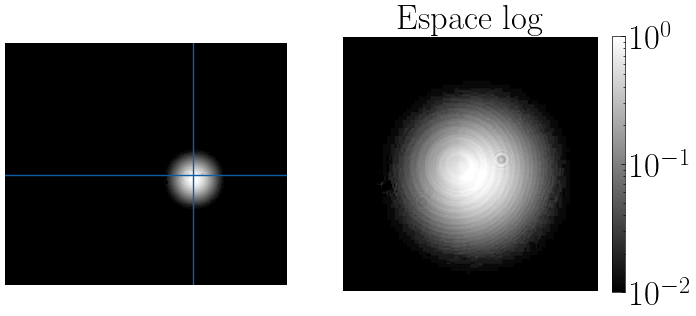

In [24]:
def channel_norm(img): 
    channel_sum = img.sum(axis = -1) # somme sur les channels
    return channel_sum / channel_sum.max()

def zooom(img, out_size):
    idx_max = np.unravel_index(img.argmax(), img.shape)   
    D_row = idx_max[0]-out_size//2
    U_row = idx_max[0]+out_size//2
    D_col = idx_max[1] - out_size//2
    U_col = idx_max[1] + out_size//2
    return img[D_row:U_row, D_col:U_col], idx_max

pad = (1024, 1024, 1024, 1024)
raw_img = channel_norm(plt.imread(fname))
pad_img = np.pad(raw_img, pad_width = 256)
img, idx_max = zooom(pad_img, out_size =512)

norm = LogNorm(vmin = 1e-2, vmax = 1, clip = True)
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
ax = axs[0]
ax.imshow(pad_img, cmap = "grey", norm = norm)
ax.axhline(idx_max[0])
ax.axvline(idx_max[1])
ax.axis('off')

ax = axs[1]
im = ax.imshow(img, cmap = "grey", norm = norm)
plt.colorbar(im, fraction = 0.0455)
ax.axis('off')
ax.set_title("Espace log")

In [70]:
import warnings
def process_profile(profile, extent = 50): 
    """
    'Preprocessing' du profil avec: supression de l'offsetm et estimation std

    Args:
        extent (int, optional): _description_. Defaults to 100.
    """
    if profile[extent] > 0.05 * profile.max():
        warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")
    offset = profile[:extent].mean()
    std = profile[:extent].std() # très mauvaise assumption pour une CCD mais bon...

    profile -= offset
    mask = np.where(profile < profile.max() * 1e-2, False, True) # removing data we don't care about, a bit of a rule of thumb law here
    return profile[mask], std


def get_window(array, extent): 
    mid_idx = array.argmax()
    return array[mid_idx - extent:mid_idx + extent]

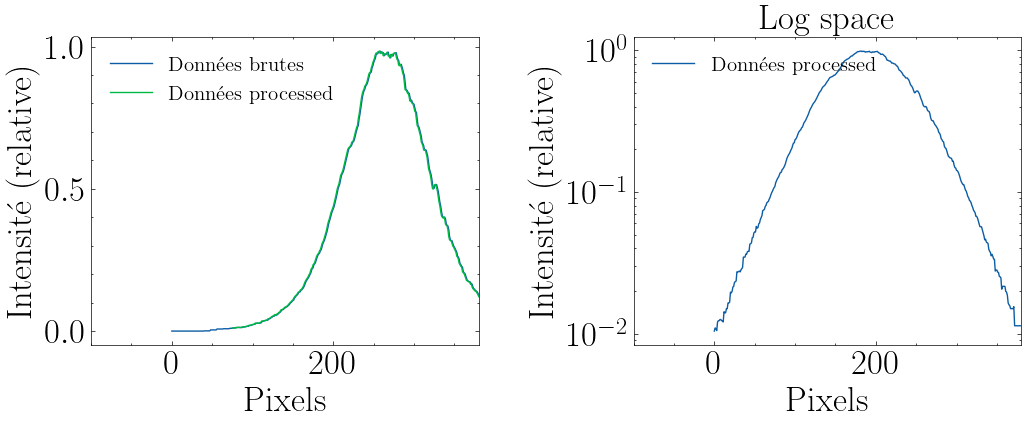

In [100]:
# Calcul du profil suivi par les pixels :)
raw_profile = img.sum(axis = 0) / img.sum(axis = 0).max() # on pourrait faire axis=1 également
extent =50
profile, std = process_profile(raw_profile, extent = extent)
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

ax = axs[0]
ax.plot(np.arange(len(raw_profile)), raw_profile, label = "Données brutes")
ax.plot(np.arange(1.5 * extent, 1.5* extent + len(profile)), profile, label = "Données processed")
ax.set(xlim = [-100,len(profile)], xlabel = "Pixels", ylabel = "Intensité (relative)")
ax.legend(loc = "upper left", fontsize = 15)


ax = axs[1]
ax.plot(profile, label = "Données processed")
ax.set(xlim = [-100,len(profile)], xlabel = "Pixels", ylabel = "Intensité (relative)")
ax.set_yscale("log")
ax.legend(loc = "upper left", fontsize = 15)
ax.set_title("Log space")
plt.subplots_adjust(wspace = 0.4)

Parfait. On peut passer maintenant au fit de la Gaussienne. Je vais m'inspirer fortement du premier notebook de lab, puisqu'on a fait exactement la même chose; on utilise la fonction wfit de notre classe `FrequentistLinearRegression`. 

In [72]:
from regression import FrequentistRegression

# Definition de quelques fonctions pour la Gaussienne
def gaussian_profile(wavelength, I0, wavelength_center, width): 
    I = I0 * np.exp( -0.5 * (wavelength - wavelength_center) ** 2 / (width) ** 2)
    return I

# Passage des paramètres de régression aux paramètres physique  (= leurs déviations standards associés)
def params_to_phys(params, std_params): 
    beta0, beta1, beta2 = params
    std_beta0, std_beta1, std_beta2 = std_params
    var = -1 / (2 * beta2)
    mu = - beta1 / (2 * beta2)
    A = np.exp(beta0 + mu ** 2 / (2 * var))

    std_var = std_beta2 / (2 * beta2 ** 2)
    # std_mu = np.sqrt(var ** 2 * std_beta1 ** 2 + std_var ** 2 * beta1 ** 2)
    std_mu = np.sqrt( (std_beta1 / (2 * beta2)) ** 2 + (beta1 * std_beta2 / (2*beta2 ** 2))**2)
    std_A = A * np.sqrt(std_beta0 ** 2 + mu ** 2 / (var) ** 2 * std_mu ** 2 + std_var ** 2 * (mu / var) ** 4)
    return np.array([A, mu, var]), np.array([std_A, std_mu, std_var])

y = np.log(profile)
x = np.arange(len(profile))
sigma_y = std / profile
# Ajustement des paramètres de régression
Regression_gaussian = FrequentistRegression(
    degree = 2,
    sigma_noise = sigma_y * 20, # sigma change pour cette version en espace des log après propagation des incertitudes 
) 

params_fitted, std_fitted = Regression_gaussian.wfit(
    obs = y, 
    x = x, 
    ridge_reg = 1e-12, 
    fit_intercept = True
)

chi2 = Regression_gaussian.compute_chi2(
    obs = y
)
print( "chi", chi2)

# Calcul des paramètres physiques associés aux paramètres de régression
# phys_fitted, phys_std = params_to_phys(params_fitted, std_fitted)

y_pred = Regression_gaussian.forward_model()

print(Regression_gaussian.cov)

chi 1.5402457404177758
[[ 1.30221290e-03 -1.34371111e-05  3.34526455e-08]
 [-1.34371111e-05  1.42639868e-07 -3.63953743e-10]
 [ 3.34526455e-08 -3.63953743e-10  9.50601419e-13]]


In [73]:
print(params_fitted)
print(std_fitted)

[-6.21575645e+00  6.46329936e-02 -1.69175694e-04]
[3.60861871e-02 3.77676936e-04 9.74987907e-07]


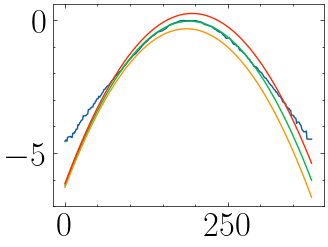

In [74]:
plt.plot(x, y)
plt.plot(x, y_pred)
Regression_gaussian.coeff_fitted = params_fitted -  k * std_fitted
ymin = Regression_gaussian.forward_model()
Regression_gaussian.coeff_fitted = params_fitted +  k * std_fitted
ymax = Regression_gaussian.forward_model()
plt.plot(x, ymin)
plt.plot(x, ymax)


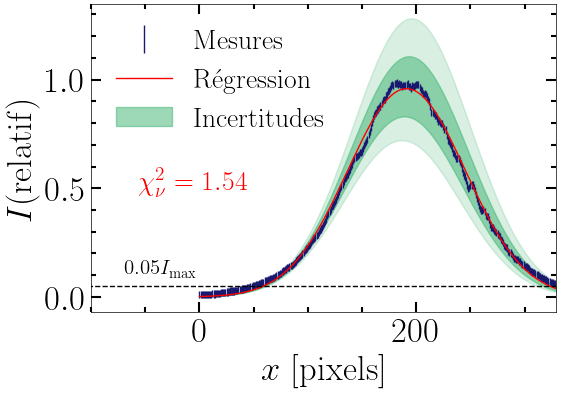

In [114]:
fig, axs = plt.subplots(1, 1, figsize = (6, 4))

ax =axs
ax.errorbar(x, profile, fmt = '.', yerr = std * 20, color = 'midnightblue', markersize = 1e-5, label = "Mesures") 

ax.plot(x, np.exp(y_pred), color = 'red', label = "Régression")
k = 1
Regression_gaussian.coeff_fitted = params_fitted -  k * std_fitted
ymin = Regression_gaussian.forward_model()
Regression_gaussian.coeff_fitted = params_fitted +  k * std_fitted
ymax = Regression_gaussian.forward_model()
ax.fill_between(
    x = x,
    y1 = np.exp(ymin), 
    y2 = np.exp(ymax), 
    color = 'mediumseagreen',
    alpha = 0.5,
    label = 'Incertitudes'
)
k = 2
Regression_gaussian.coeff_fitted = params_fitted -  k * std_fitted
ymin = Regression_gaussian.forward_model()
Regression_gaussian.coeff_fitted = params_fitted +  k * std_fitted
ymax = Regression_gaussian.forward_model()

xmin = x.min() - 100
xmax = x.max() -50
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.1, 0.4), xycoords = 'axes fraction', color = 'r', fontsize = 20)
ax.set(xlabel = r"$x$ [pixels]", ylabel = r"$I$(relatif)", xlim = (xmin, xmax))
ax.fill_between(
    x = x,
    y1 = np.exp(ymin), 
    y2 = np.exp(ymax), 
    color = 'mediumseagreen',
    alpha = 0.2
)
ax.axhline(0.05, xmin = xmin, xmax = xmax, color = "k", linestyle = '--')
# ax.axvline(y_pred.argmax(), color = "k", linestyle = '--')
ax.annotate(r"$0.05 I_{\max}$", xy = (xmin+30, 0.1), fontsize = 15)
# ax.annotate(r"$\text{argmax}_{x} I$", xy = (y_pred.argmax()-90, 0.1), fontsize = 15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left")
plt.savefig(figure_folder + "3b_rouge_mono_22mm.pdf", bbox_inches = 'tight')

In [128]:
def get_radius(profile_fitted, std_profile, pixel_size = 5.2 * u.micrometer):
    rel = np.argmin(abs(0.05 * profile_fitted.max() - profile_fitted))
    rel_max = np.argmin(abs(0.05 * (profile_fitted + std_profile).max() - profile_fitted))
    std_rel = abs(rel_max - rel)
    pixel_extent = abs(profile_fitted.argmax() - rel)
    std_extent = std_rel # on ignore l'incertitude sur le argmax
    extent_si = pixel_extent * pixel_size.to(u.meter).value
    std_extent_si = std_extent * pixel_size.to(u.meter).value 
    return extent_si, std_extent_si 


std_pred = (np.exp(ymax) - np.exp(y_pred)) # plutôt mauvais mais c'est ok étant donné nos hypothèses initiales...
R, std_R = get_radius(profile_fitted=np.exp(y_pred), std_profile=std_pred)
print(R, std_R)
# na = get_na(R, d)
# std_na = get_std_na(R, d, std_R, std_d=sigma_distance)
# print(f"NA = {na:.2g} +/- {std_na:.2g}")

0.0006916 3.6400000000000004e-05


Let's wrap everything in a giant function that is going to output $R$ given a file given as input

In [543]:
def analyze_data(fname, extent = extent, sanity_plots = True, padding = 1024, img_size=512, save = False):
    
    d = float(os.path.basename(fname).split("_")[-2]) * u.centimeter.to(u.meter)
    print(f'Processing file with d={d:.2f} meters')
    raw_img = channel_norm(plt.imread(fname))
    pad_img = np.pad(raw_img, pad_width = padding)
    img, idx_max = zooom(pad_img, out_size = img_size)
    
    if sanity_plots: 
        print("Plotting image")
        norm = LogNorm(vmin = 1e-2, vmax = 1, clip = True)
        fig, axs = plt.subplots(1, 2, figsize = (8, 4))
        ax = axs[0]
        ax.imshow(pad_img, cmap = "grey", norm = norm)
        ax.axhline(idx_max[0])
        ax.axvline(idx_max[1])
        ax.axis('off')

        ax = axs[1]
        im = ax.imshow(img, cmap = "grey", norm = norm)
        plt.colorbar(im, fraction = 0.0455)
        ax.axis('off')
        ax.set_title("Espace log")
        
    raw_profile = img.sum(axis = 0) / img.sum(axis = 0).max() # on pourrait faire axis=1 également
    profile, std = process_profile(raw_profile, extent = extent)

    x = np.arange(len(profile))


    if sanity_plots:
        print("Plotting profile")
        fig, axs = plt.subplots(1, 2, figsize = (12, 4))

        ax = axs[0]
        ax.plot(raw_profile, label = "Données brutes")
        ax.plot(profile, label = "Données processed")
        ax.set(xlim = [-100,max(len(profile), len(raw_profile))], xlabel = "Pixels", ylabel = "Intensité (relative)")
        ax.legend(loc = "upper left", fontsize = 15)


        ax = axs[1]
        ax.plot(profile, label = "Données processed")
        ax.set(xlim = [-100,len(profile)], xlabel = "Pixels", ylabel = "Intensité (relative)")
        ax.set_yscale("log")
        ax.legend(loc = "upper left", fontsize = 15)
        ax.set_title("Log space")
        plt.subplots_adjust(wspace = 0.4)
    

    print("Fitting the Gaussian regression")
    y = np.log(profile)
    x = np.arange(len(profile))
    sigma_y = std / profile
    # Ajustement des paramètres de régression
    Regression_gaussian = FrequentistRegression(
        degree = 2,
        sigma_noise = sigma_y, # sigma change pour cette version en espace des log après propagation des incertitudes 
    ) 

    params_fitted, std_fitted = Regression_gaussian.wfit(
        obs = y, 
        x = x, 
        ridge_reg = 1e-12, 
        fit_intercept = True
    )

    chi2 = Regression_gaussian.compute_chi2(
        obs = y
    )
    print( "chi", chi2)
    y_pred = Regression_gaussian.forward_model()
    Regression_gaussian.coeff_fitted = params_fitted +  std_fitted
    ymax = Regression_gaussian.forward_model()


    if sanity_plots: 
        fig, axs = plt.subplots(1, 1, figsize = (6, 4))

        ax = axs
        ax.errorbar(x, profile, fmt = '.', yerr = std, color = 'midnightblue', markersize = 1e-5, label = "Mesures") 

        ax.plot(x, np.exp(y_pred), color = 'red', label = "Régression")
        k = 1
        Regression_gaussian.coeff_fitted = params_fitted -  k * std_fitted
        ymin = Regression_gaussian.forward_model()
        Regression_gaussian.coeff_fitted = params_fitted +  k * std_fitted
        ymax = Regression_gaussian.forward_model()
        ax.fill_between(
            x = x,
            y1 = np.exp(ymin), 
            y2 = np.exp(ymax), 
            color = 'mediumseagreen',
            alpha = 0.5,
            label = 'Incertitudes'
        )
        k = 2
        Regression_gaussian.coeff_fitted = params_fitted -  k * std_fitted
        ymin = Regression_gaussian.forward_model()
        Regression_gaussian.coeff_fitted = params_fitted +  k * std_fitted
        ymax = Regression_gaussian.forward_model()

        xmin = x.min() - 100
        xmax = x.max() -50
        ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
        ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
        ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.1, 0.4), xycoords = 'axes fraction', color = 'r', fontsize = 20)
        ax.set(xlabel = r"$x$ [pixels]", ylabel = r"$I$(relatif)", xlim = (xmin, xmax))
        ax.fill_between(
            x = x,
            y1 = np.exp(ymin), 
            y2 = np.exp(ymax), 
            color = 'mediumseagreen',
            alpha = 0.2
        )
        ax.axhline(0.05, xmin = xmin, xmax = xmax, color = "k", linestyle = '--')
        ax.annotate(r"$0.05 I_{\max}$", xy = (xmin+30, 0.1))
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2,0,1]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left")
        
        if save: 
            plt.savefig(figure_folder + f"monomode_rouge{d}.pdf", bbox_inches = "tight")
        else: 
            ax.set_title(r"$d=%.2f$"%d)

    std_pred = (np.exp(ymax) - np.exp(y_pred)) # plutôt mauvais mais c'est ok étant donné nos hypothèses initiales...
    R, std_R = get_radius(profile_fitted=np.exp(y_pred), std_profile=std_pred)
    print(R)
    return (R, std_R, d, sigma_distance * u.centimeter.to(u.meter))

def get_na(slope): 
    return slope / (np.sqrt(slope ** 2 + 1))

def get_std_na(slope, std_slope):
    return std_slope  / (slope**2 + 1) ** (3 / 2)

def model(x, params_fitted): 
    return params_fitted[0] + params_fitted[1] * x

def std_model(x, sigma_x, params_fitted, std_fitted):
    beta_0, beta_1 = params_fitted 
    std_beta0, std_beta1 = std_fitted 
    return np.sqrt(std_beta0 ** 2 + std_beta1 ** 2 * x **2 + sigma_x ** 2 * beta_1 ** 2) 

def monomode_na(R, d, std_r, std_d, sanity_plots = True, save = True, filename = "3b_blue"):
    x = d * 1e2 # centimètres
    y = R * 1e2
    sigma_x = std_d *1e2
    sigma_y = std_r * 1e2

    Regression_multimode = FrequentistRegression(
        degree = 1,
        sigma_noise = sigma_y
    )


    params_fitted, std_fitted = Regression_multimode.fit(
        obs = y, 
        x = x,
        ridge_reg = 1e-12,
        fit_intercept = True
    )

    y_pred = Regression_multimode.forward_model()
    cov = Regression_multimode.cov
    chi2 = Regression_multimode.compute_chi2(obs = y)
    # print(y, y_pred)
    # print(model(x, params_fitted))
    xmin = 1
    xmax = x.max() + 1
    if sanity_plots:
        fig, axs = plt.subplots(1, 1, figsize = (6, 4))
        ax = axs
        x_fill = np.linspace(xmin, xmax, 1000)
        y_pred = model(x_fill, params_fitted) - params_fitted[0]# prédiction du modèle de régression linéaire
        print(sigma_x.shape)
        std_reg = std_model(x_fill, sigma_x, params_fitted, std_fitted)
        std_tot = np.sqrt(std_reg ** 2 + sigma_y ** 2)

        # Mettre mesures et régression linéaire 
        ax.errorbar(x, y-params_fitted[0],  xerr = sigma_x, yerr = sigma_y, fmt = ".", color = "midnightblue", label = "Mesures")
        ax.plot(x_fill, y_pred, color = "green", label = "Régression linéaire")

        # Première zone d'incertitude
        k = 1
        ax.fill_between(
            x = x_fill, 
            y1=y_pred - k * std_tot, 
            y2 = y_pred + k * std_tot, 
            color = "mediumseagreen",
            label = "Incertitudes", 
            alpha  = 0.5
        )

        k = 2
        ax.fill_between(
            x = x_fill, 
            y1=y_pred - k * std_tot, 
            y2 = y_pred + k * std_tot, 
            color = "mediumseagreen",
            alpha  = 0.3
        )

        ax.set(xlim = [xmin, xmax], ylim = [-0.5, y.max()+2 ], xlabel = r"$d$[cm]", ylabel = r"$R$[cm]")
        ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.08, 0.4), xycoords = "axes fraction", color = "red", fontsize = 20)
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2,0,1]
        ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
        ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
        ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])
        ax.legend()
        
        if save: 
            plt.savefig(figure_folder + f"{filename}_R.pdf", bbox_inches = "tight")


    return get_na(slope = params_fitted[1]), get_std_na(slope = params_fitted[1], std_slope = std_fitted[1])


In [396]:
from glob import glob

pattern = figure_folder + "3b_rouge_*_mode1.jpg"
paths = glob(pattern)

# R, std_R, d, std_d = analyze_data(paths[4], extent = 50, sanity_plots = True, padding = 1024, img_size = 1024)
R_rouge, std_r_rouge, d_rouge, std_d_rouge = [], [], [], []
extents = [150, 300, 300, 300, 300] # on pourrait fine-tune pour avoir les meilleurs chi squared mais bon.
img_sizes = [512, 1024, 1024, 1024, 512]
for i, path in enumerate(paths):
    data = analyze_data(path, extent = extents[i], sanity_plots = False, padding = 1024, img_size = img_sizes[i], save = True)
    R_rouge.append(data[0])
    std_r_rouge.append(data[1])
    d_rouge.append(data[2])
    std_d_rouge.append(data[3])
R_rouge, std_r_rouge, d_rouge, std_d_rouge = np.array(R_rouge), np.array(std_r_rouge), np.array(d_rouge), np.array(std_d_rouge)

Processing file with d=0.02 meters
Fitting the Gaussian regression
chi 0.29262087422571126
0.0006656
Processing file with d=0.02 meters
Fitting the Gaussian regression
chi 18.62842112699505
0.0009048
Processing file with d=0.03 meters


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\2489117340.py:10: UserWarning: Le paramètre extent choisi est possiblement trop grand, attention...
  warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")


Fitting the Gaussian regression
chi 1.3371693701524692
0.0010348
Processing file with d=0.03 meters
Fitting the Gaussian regression
chi 0.23966810040810732
0.0011232
Processing file with d=0.02 meters
Fitting the Gaussian regression
chi 0.0033631107959307825
0.0003588


Next function we'll heavily need is the one to do the linear regression of $(d, R)$. We can just do that using the linear regression code at the beginning of the notebook.

()
0.1038788564677083 0.06288850780096818


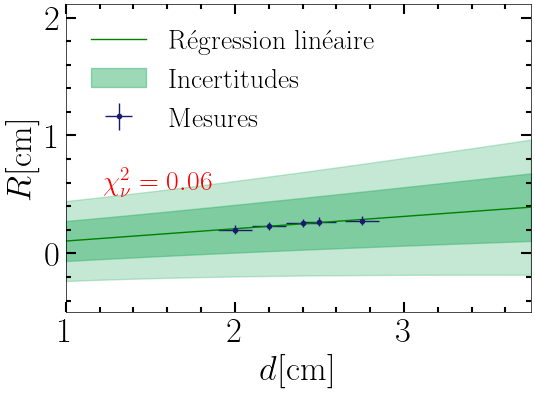

In [399]:
na_rouge, std_na_rouge = monomode_na(
    R = R_rouge, 
    d = d_rouge, 
    std_r = std_r_rouge.mean(), 
    std_d = std_d_rouge.mean(),
    sanity_plots = True,
    save = True,
    filename = "3b_rouge"
)
print(na_rouge, std_na_rouge)

### 3B bleu

Processing file with d=0.02 meters
Plotting image


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\2489117340.py:10: UserWarning: Le paramètre extent choisi est possiblement trop grand, attention...
  warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")


Plotting profile
Fitting the Gaussian regression
chi 0.27879650567325825
0.00040040000000000003
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.011749776165113827
0.000494
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 1.3355045094221363
0.0005928
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.38261459062659714
0.0007228
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.14841595900648594
0.000442


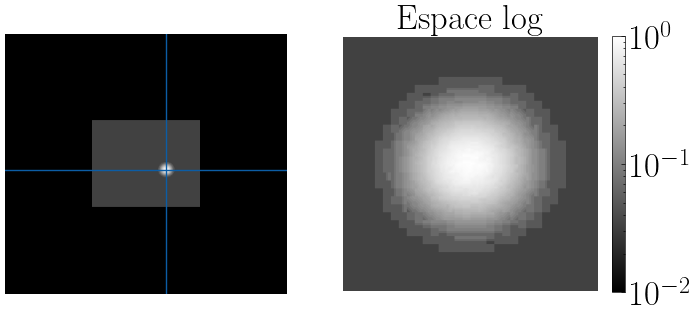

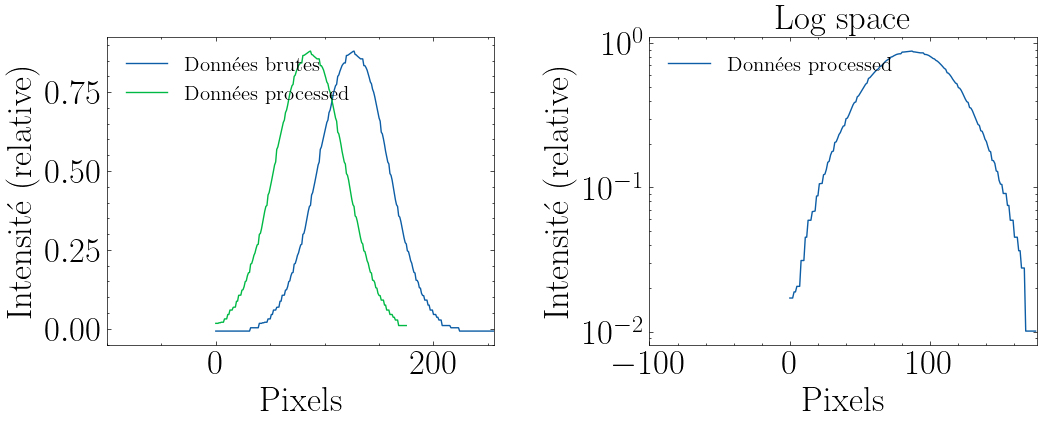

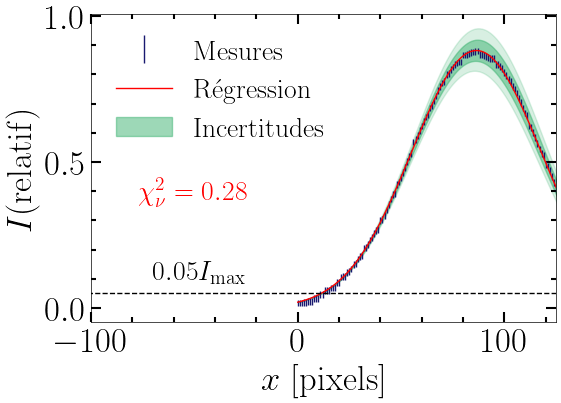

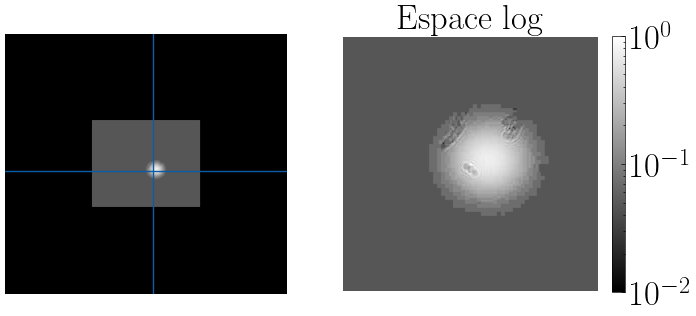

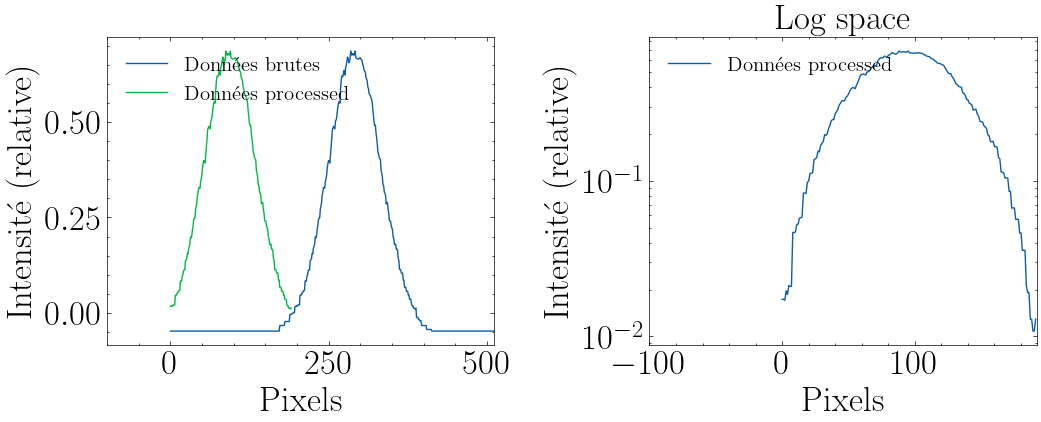

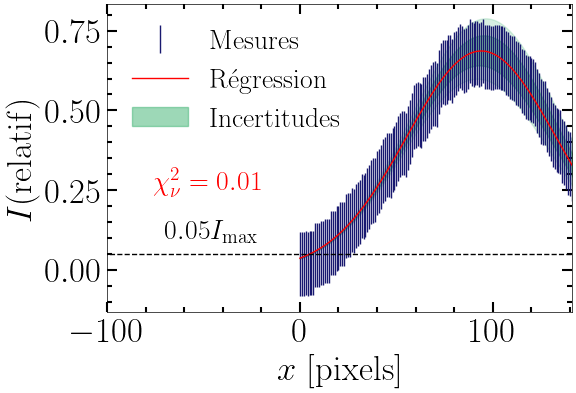

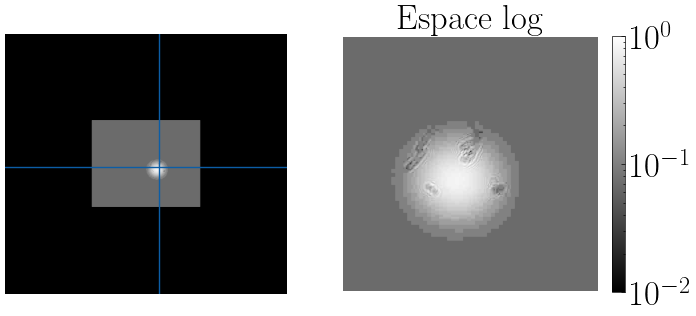

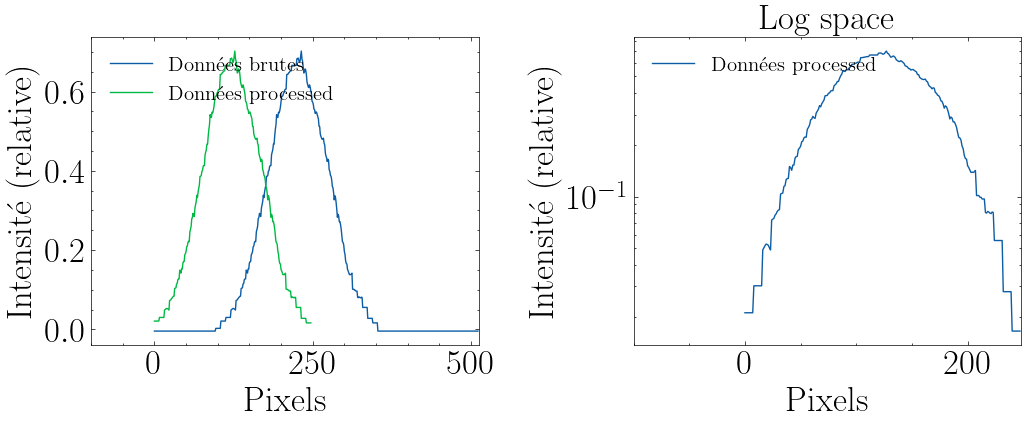

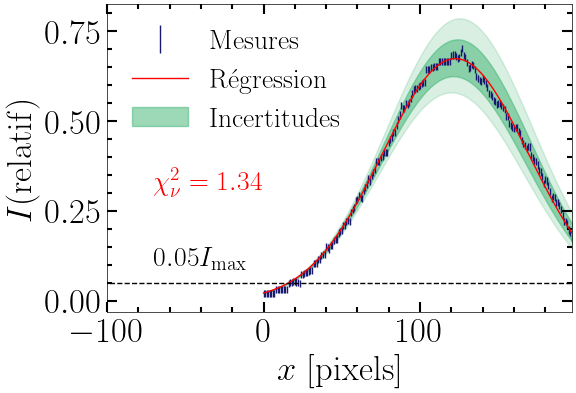

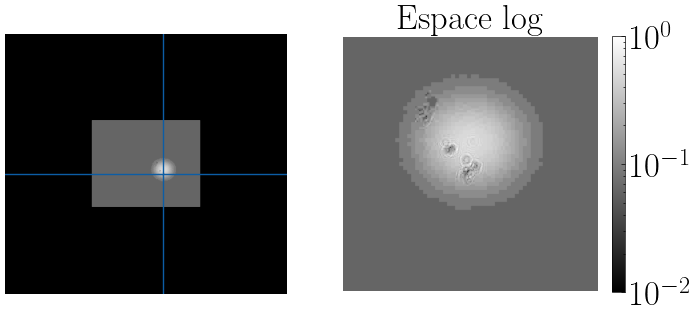

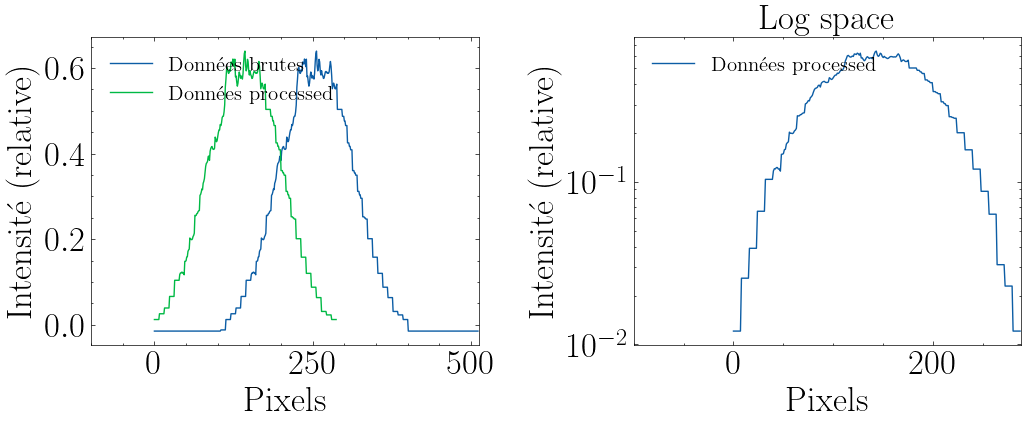

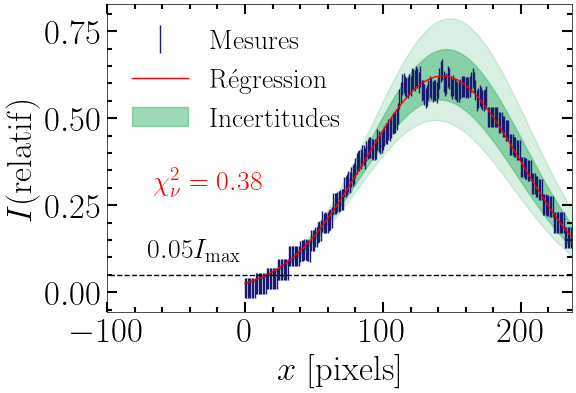

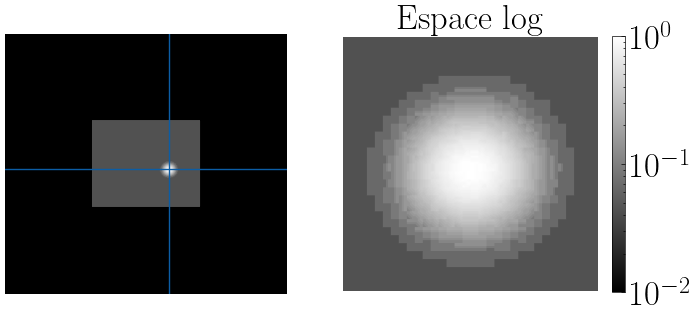

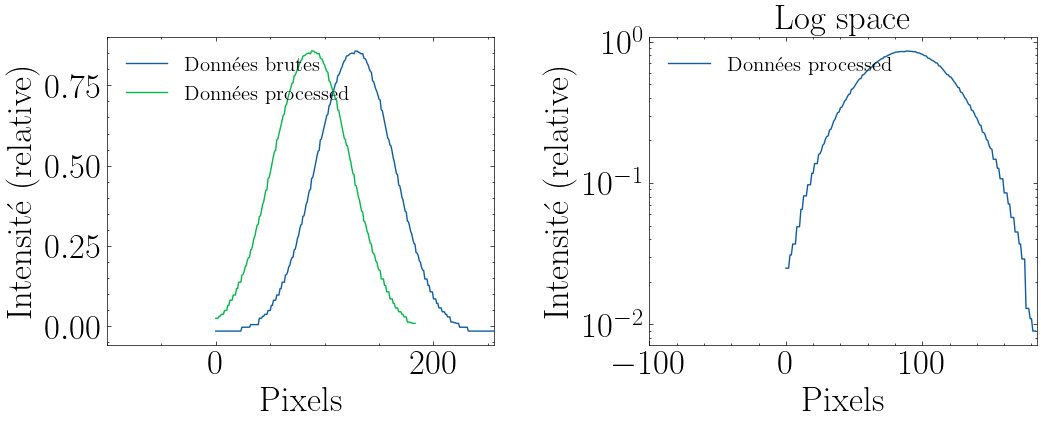

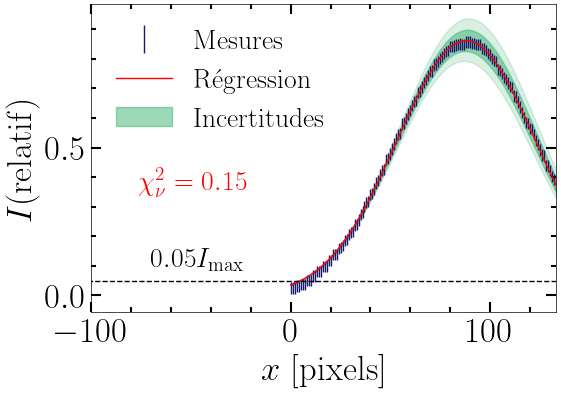

In [418]:
from glob import glob

pattern = figure_folder + "3b_blue_*_mode1.jpg"
paths = glob(pattern)

# R, std_R, d, std_d = analyze_data(paths[4], extent = 50, sanity_plots = True, padding = 1024, img_size = 1024)
R_bleu, std_r_bleu, d_bleu, std_d_bleu = [], [], [], []
extents = [50, 250, 120, 150, 50] # on pourrait fine-tune pour avoir les meilleurs chi squared mais bon.
img_sizes = [256, 512, 512, 512, 256]
for i, path in enumerate(paths):
    data = analyze_data(path, extent = extents[i], sanity_plots = True, padding = 1024, img_size = img_sizes[i], save = True)
    R_bleu.append(data[0])
    std_r_bleu.append(data[1])
    d_bleu.append(data[2])
    std_d_bleu.append(data[3])
R_bleu, std_r_bleu, d_bleu, std_d_bleu = np.array(R_bleu), np.array(std_r_bleu), np.array(d_bleu), np.array(std_d_bleu)

()
0.07930938991720114 0.05896596605997322


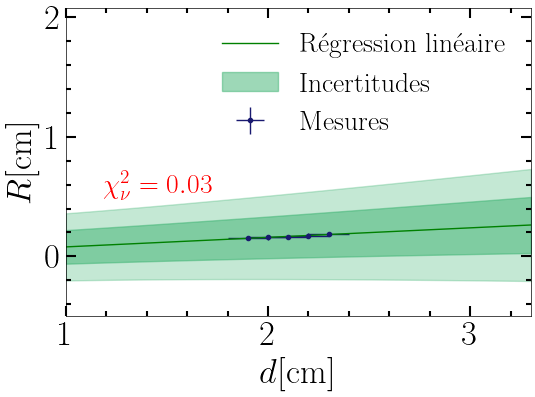

In [419]:
na_bleu, std_na_bleu = monomode_na(
    R = R_bleu, 
    d = d_bleu, 
    std_r = std_r_bleu.mean(), 
    std_d = std_d_bleu.mean(),
    sanity_plots = True,
    save = True,
    filename = "3b_blue"
)
print(na_bleu, std_na_bleu)

## 3B vert

Processing file with d=0.02 meters
Plotting image


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\2489117340.py:10: UserWarning: Le paramètre extent choisi est possiblement trop grand, attention...
  warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")


Plotting profile
Fitting the Gaussian regression
chi 0.8474919265982381
0.0005876
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.2621535697459926
0.0008528
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 50003.049734157896
0.0007696000000000001
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 305.5351928076504
0.001092
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 22.174280609968623
0.0014352


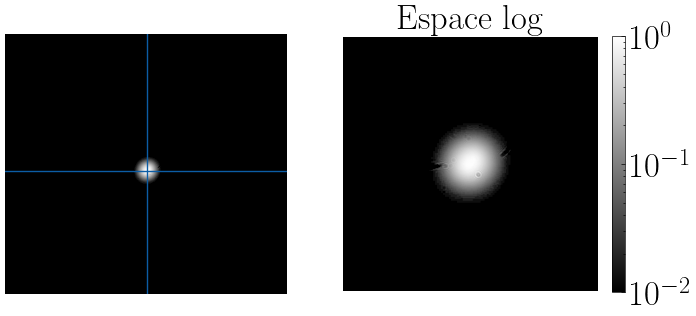

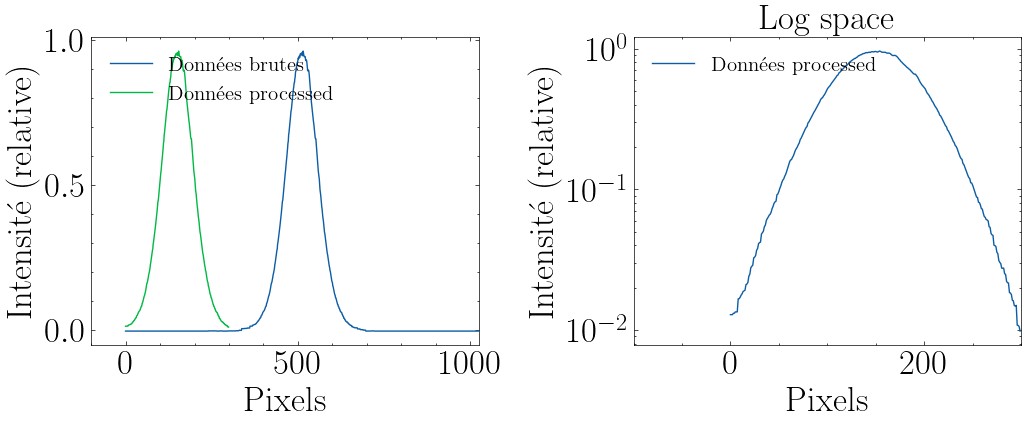

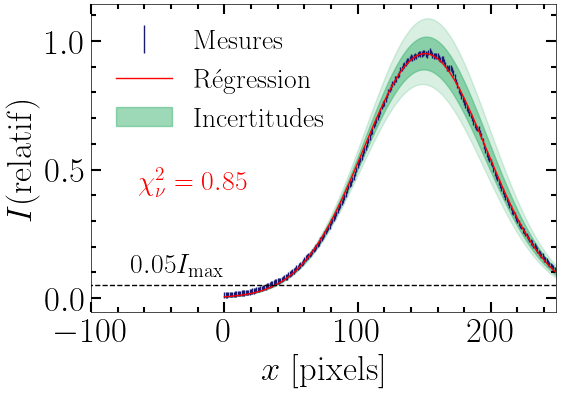

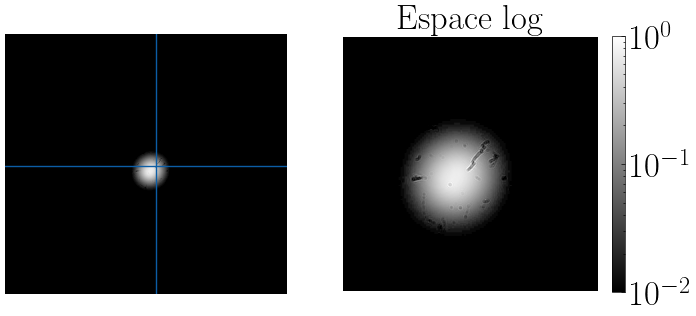

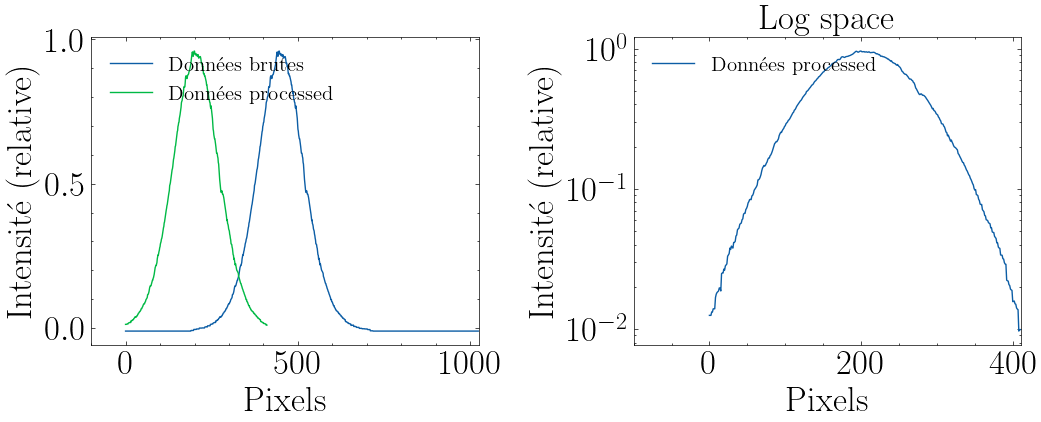

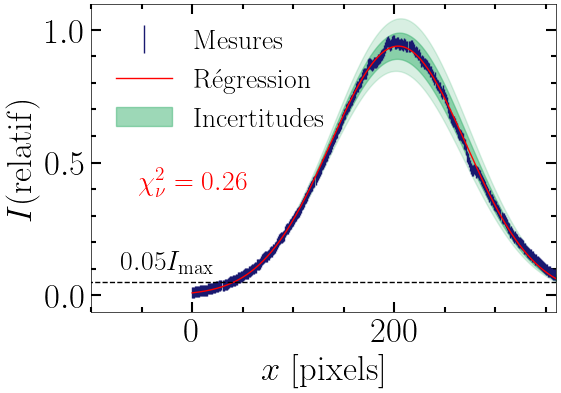

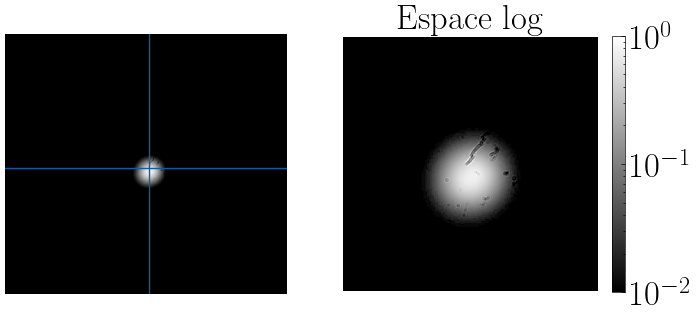

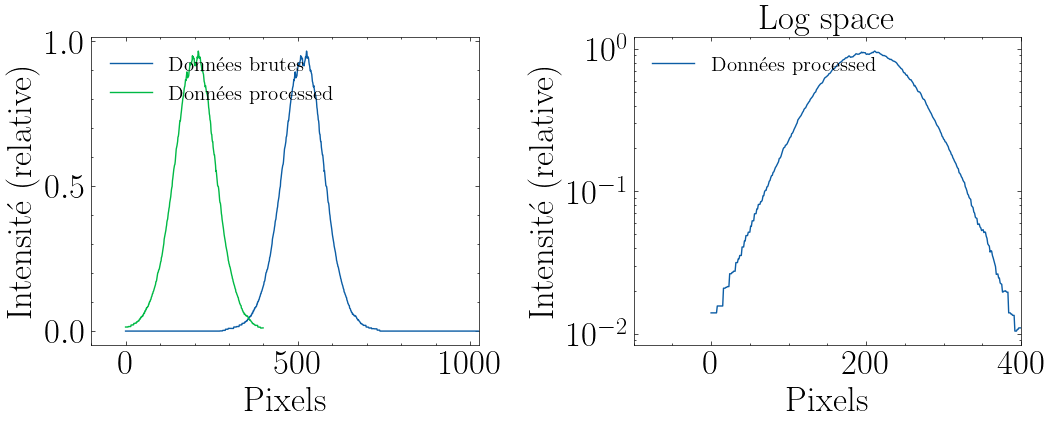

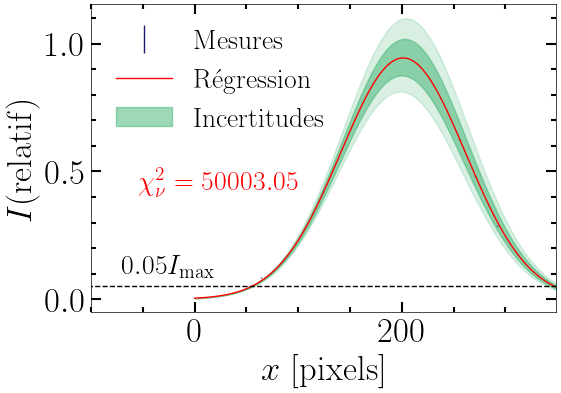

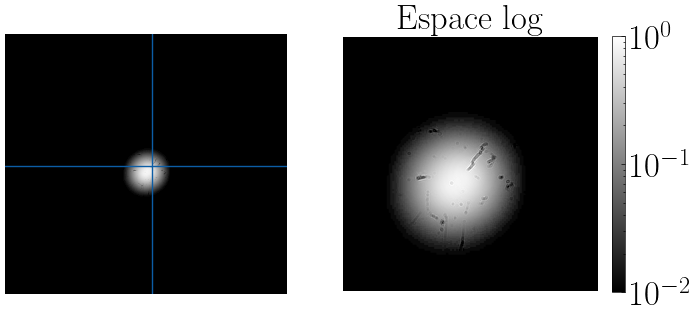

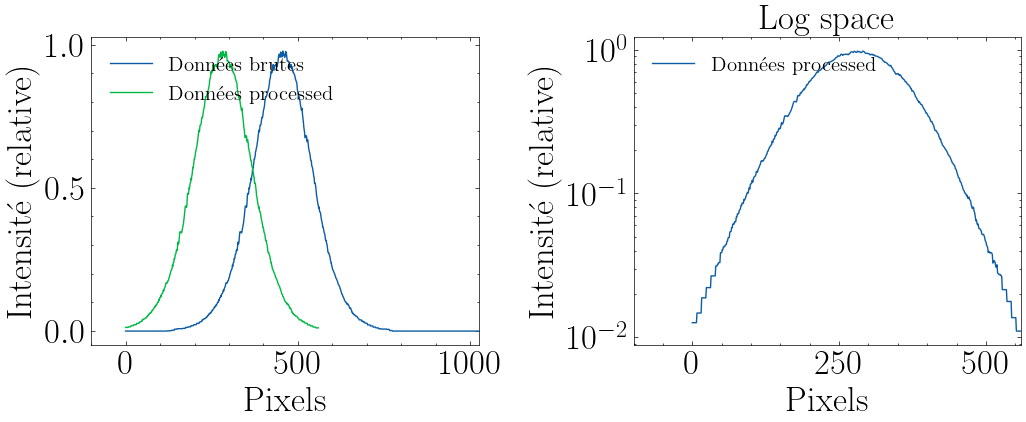

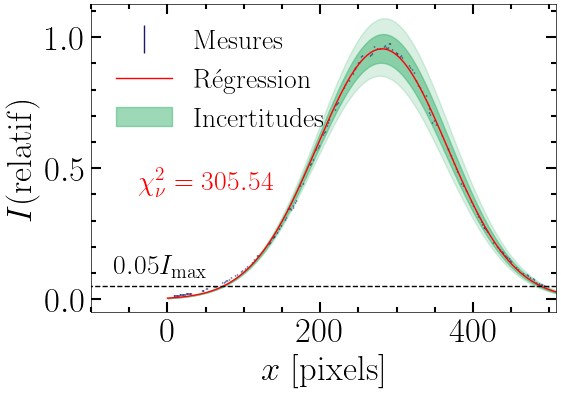

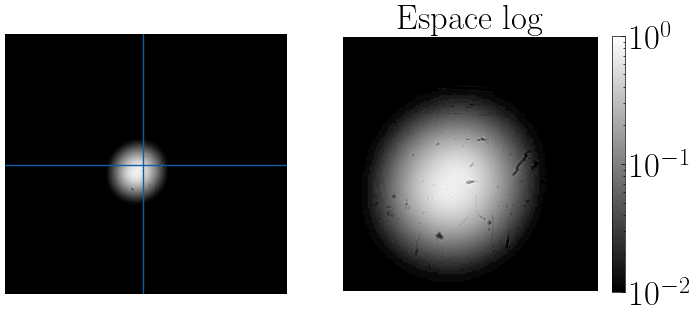

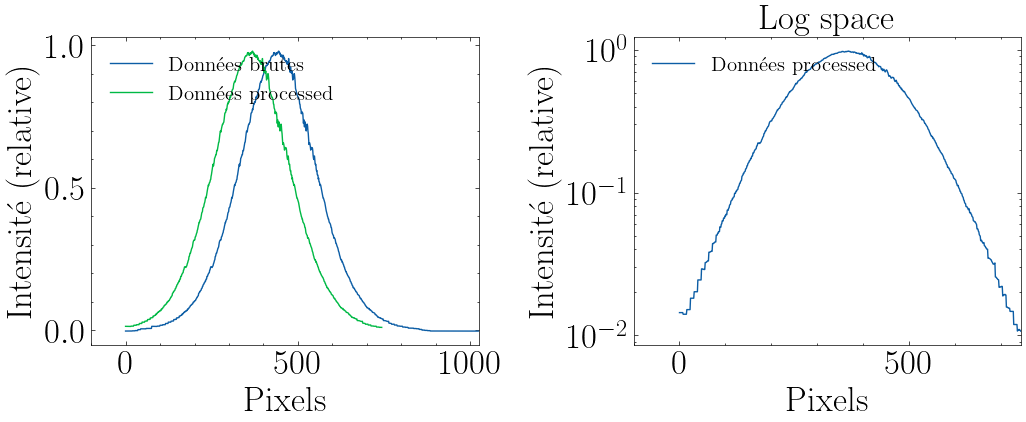

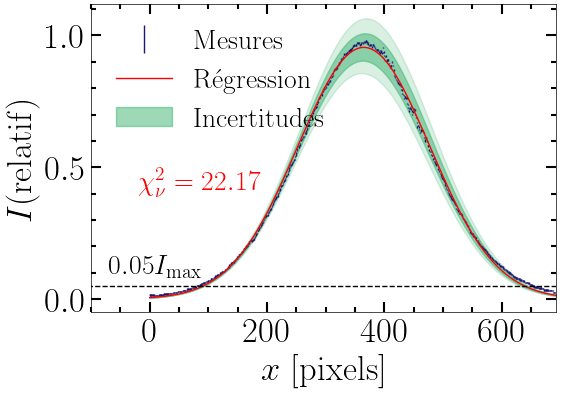

In [471]:
from glob import glob

pattern = figure_folder + "3b_green_*_mode1.jpg"
paths = glob(pattern)

# R, std_R, d, std_d = analyze_data(paths[4], extent = 50, sanity_plots = True, padding = 1024, img_size = 1024)
R_vert, std_r_vert, d_vert, std_d_vert = [], [], [], []
extents = [400, 300, 200, 140, 50] # on pourrait fine-tune pour avoir les meilleurs chi squared mais bon.
img_sizes = [1024, 1024, 1024, 1024, 1024]
for i, path in enumerate(paths):
    data = analyze_data(path, extent = extents[i], sanity_plots = True, padding = 1024, img_size = img_sizes[i], save = True)
    R_vert.append(data[0])
    std_r_vert.append(data[1])
    d_vert.append(data[2])
    std_d_vert.append(data[3])
R_vert, std_r_vert, d_vert, std_d_vert = np.array(R_vert), np.array(std_r_vert), np.array(d_vert), np.array(std_d_vert)

()
0.11643544870622728 0.047237296702020745


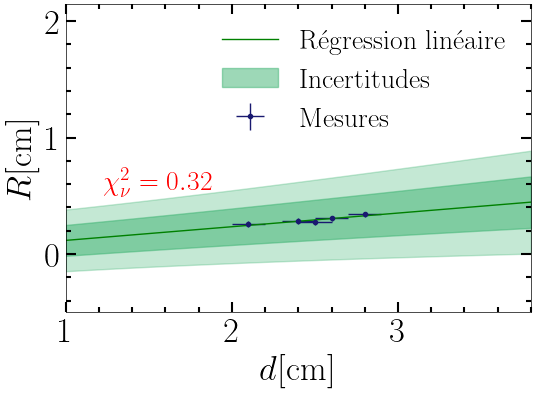

In [472]:
na_vert, std_na_vert = monomode_na(
    R = R_vert, 
    d = d_vert, 
    std_r = std_r_vert.mean(), 
    std_d = std_d_vert.mean(),
    sanity_plots = True,
    save = True,
    filename = "3b_green"
)
print(na_vert, std_na_vert)

## Analyse pour fibre 3A

Processing file with d=0.03 meters
Plotting image


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\2489117340.py:10: UserWarning: Le paramètre extent choisi est possiblement trop grand, attention...
  warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")


Plotting profile
Fitting the Gaussian regression
chi 0.006288977300531149
0.0015184
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 5.526766955418112
0.0020852
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.007431418423821091
0.0023504
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.04162644493486929
0.0024128


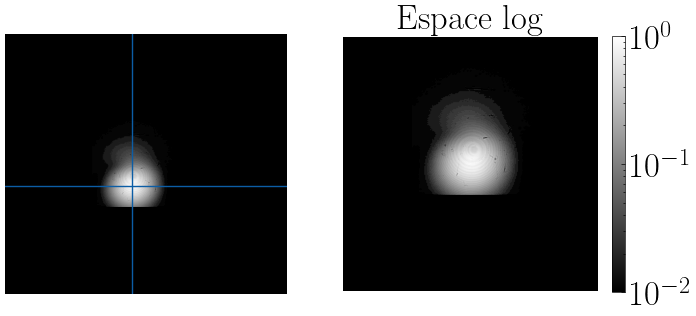

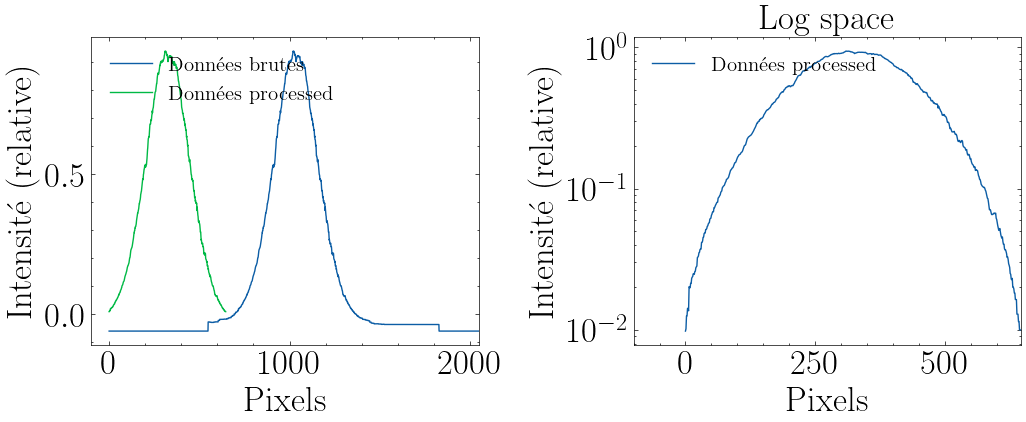

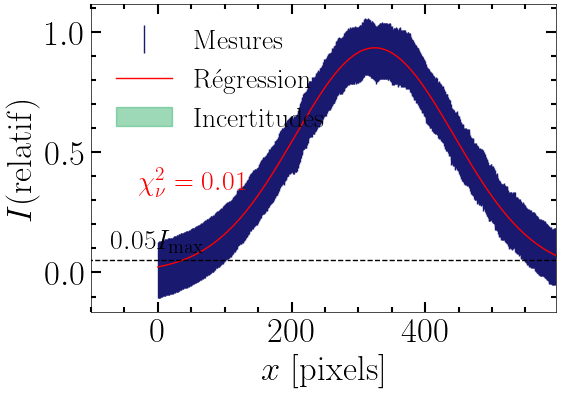

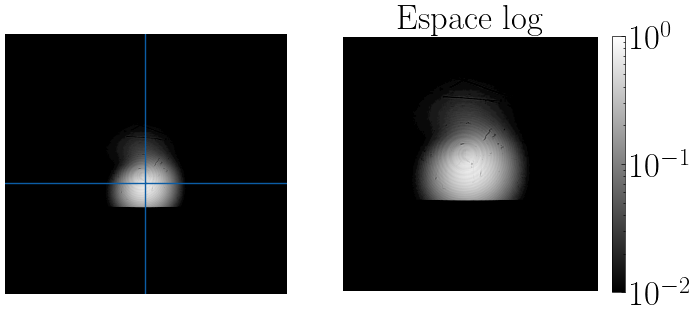

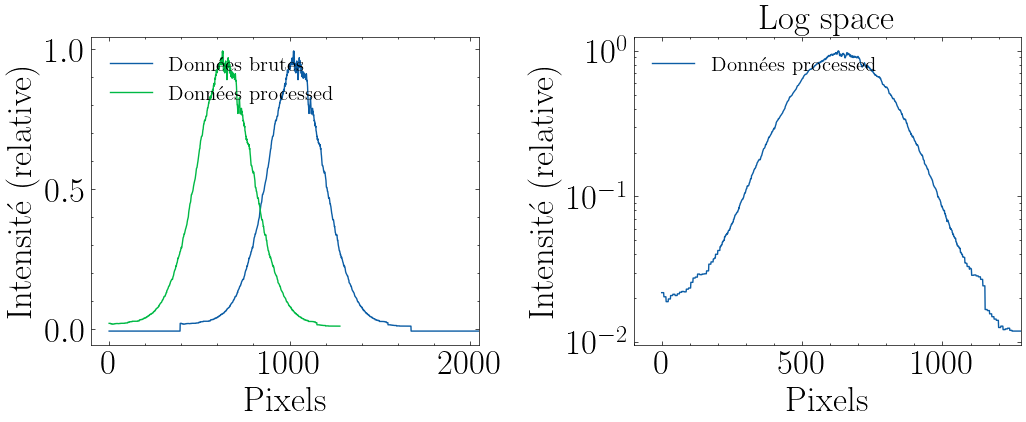

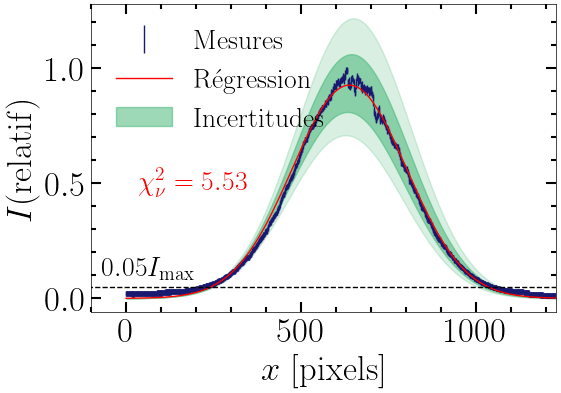

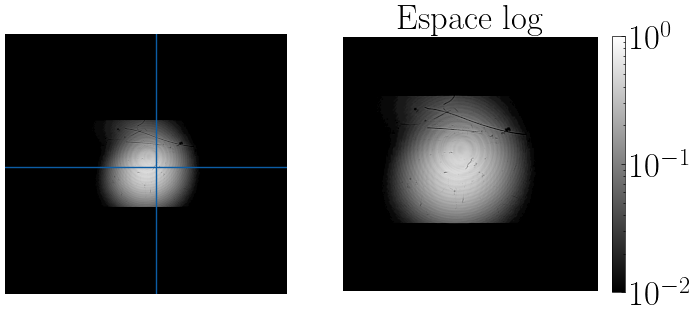

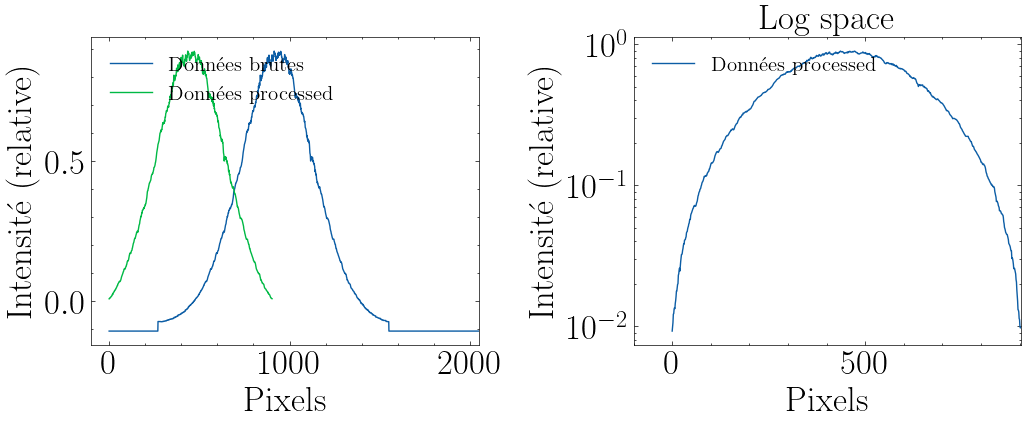

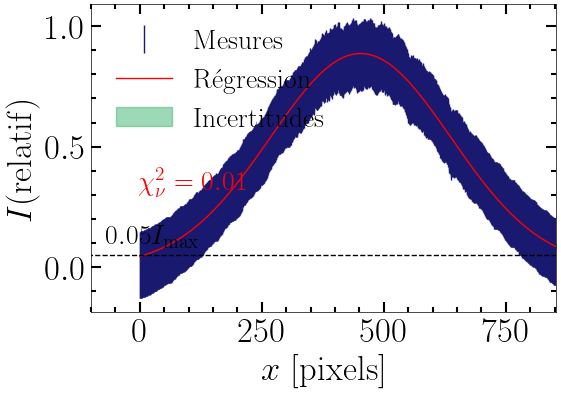

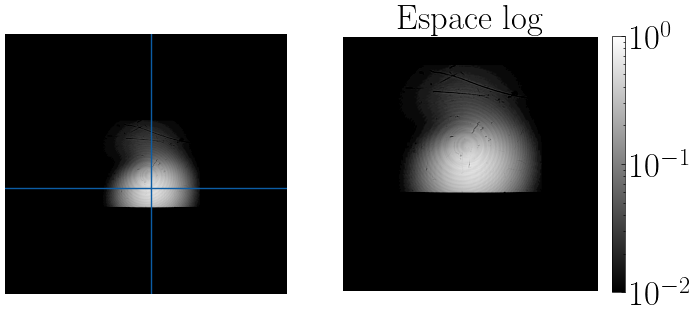

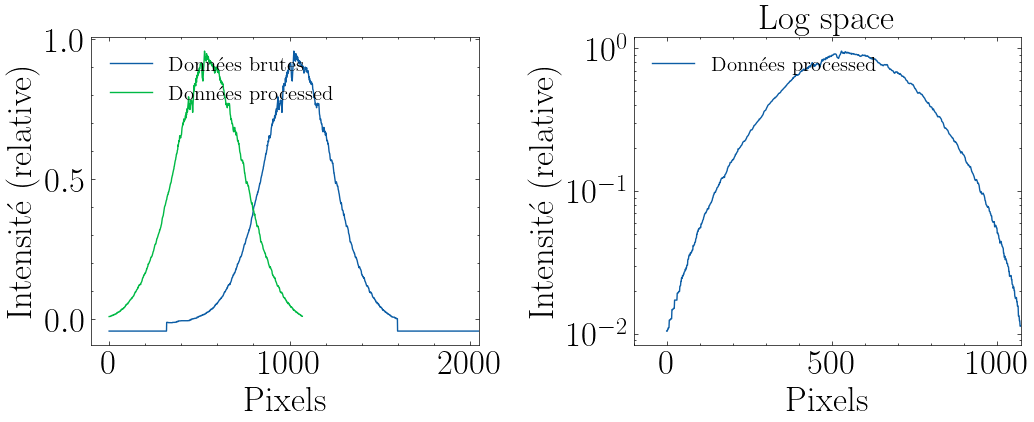

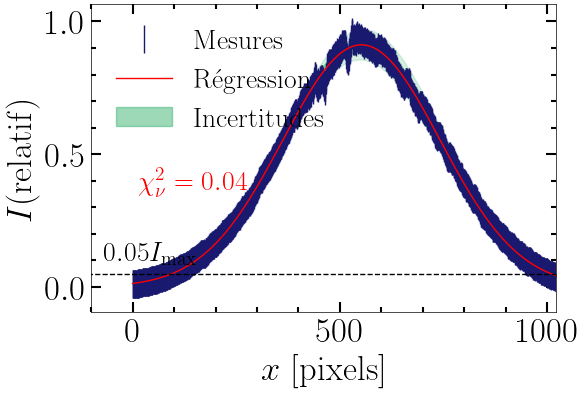

In [511]:
from glob import glob

pattern = figure_folder + "3a_red_*_mode1.jpg"
paths = glob(pattern)

# R, std_R, d, std_d = analyze_data(paths[4], extent = 50, sanity_plots = True, padding = 1024, img_size = 1024)
R_rouge, std_r_rouge, d_rouge, std_d_rouge = [], [], [], []
extents = [900, 500, 700, 700, 800] # on pourrait fine-tune pour avoir les meilleurs chi squared mais bon.
img_sizes = [2048, 2048, 2048, 2048, 2048]
for i, path in enumerate(paths):
    data = analyze_data(path, extent = extents[i], sanity_plots = True, padding = 1024, img_size = img_sizes[i], save = True)
    R_rouge.append(data[0])
    std_r_rouge.append(data[1])
    d_rouge.append(data[2])
    std_d_rouge.append(data[3])
R_rouge, std_r_rouge, d_rouge, std_d_rouge = np.array(R_rouge), np.array(std_r_rouge), np.array(d_rouge), np.array(std_d_rouge)

In [483]:
std_r_rouge

array([1.664e-04, 9.880e-05, 1.560e-05, 2.600e-05])

()
0.10690152931537407 0.006574120319273347


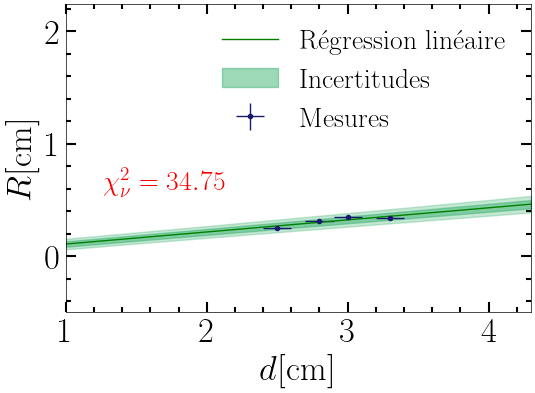

In [512]:
na_rouge, std_na_rouge = monomode_na(
    R = R_rouge, 
    d = d_rouge, 
    std_r = std_r_rouge.mean(), 
    std_d = std_d_rouge.mean(),
    sanity_plots = True,
    save = True,
    filename = "3a_rouge"
)
print(na_rouge, std_na_rouge)

Processing file with d=0.02 meters
Plotting image


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\2489117340.py:10: UserWarning: Le paramètre extent choisi est possiblement trop grand, attention...
  warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")


Plotting profile
Fitting the Gaussian regression
chi 0.0014186572878792884
0.000754
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.0007736932443886636
0.0008892
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.0009568372772101838
0.0010400000000000001
Processing file with d=0.02 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.0056585034406451615
0.0006448000000000001
Processing file with d=0.03 meters
Plotting image
Plotting profile
Fitting the Gaussian regression
chi 0.0009267691471843629
0.0012064


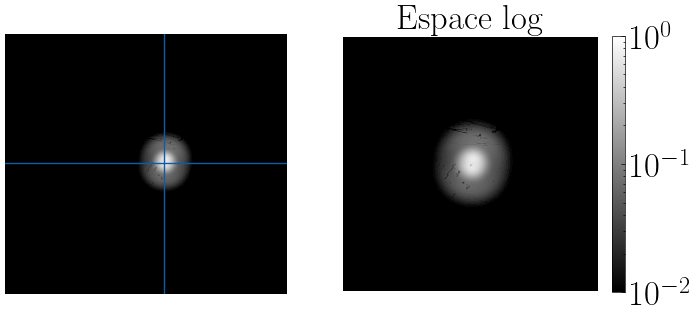

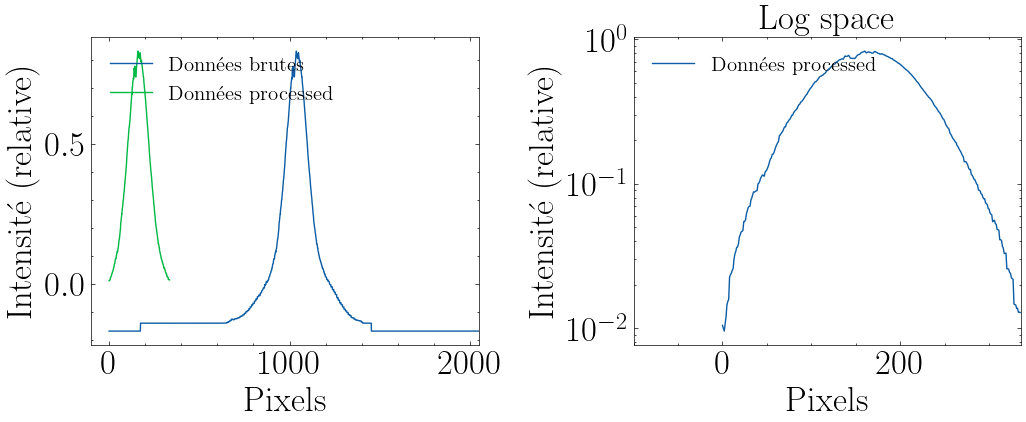

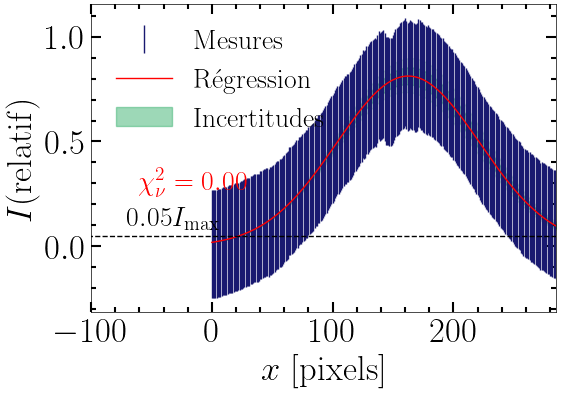

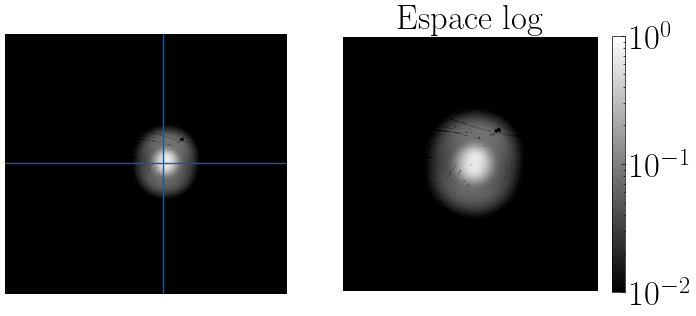

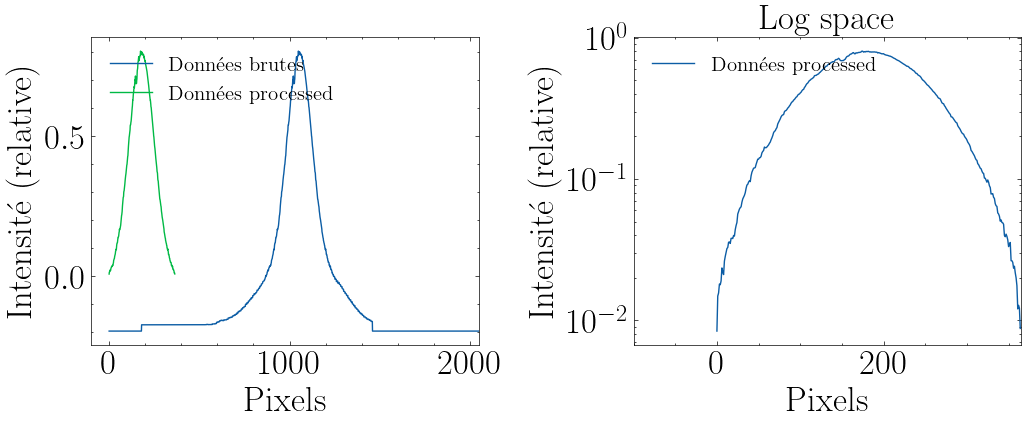

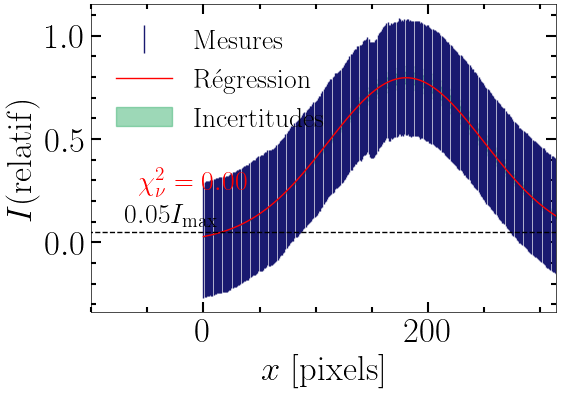

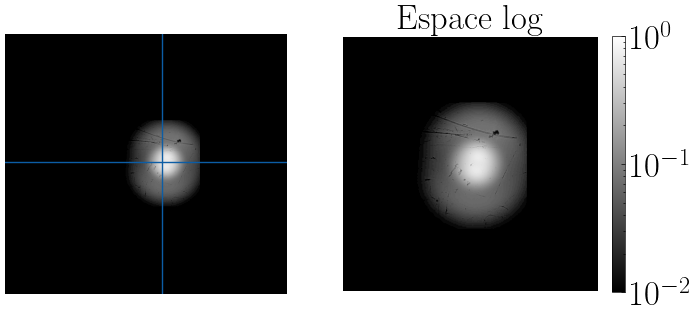

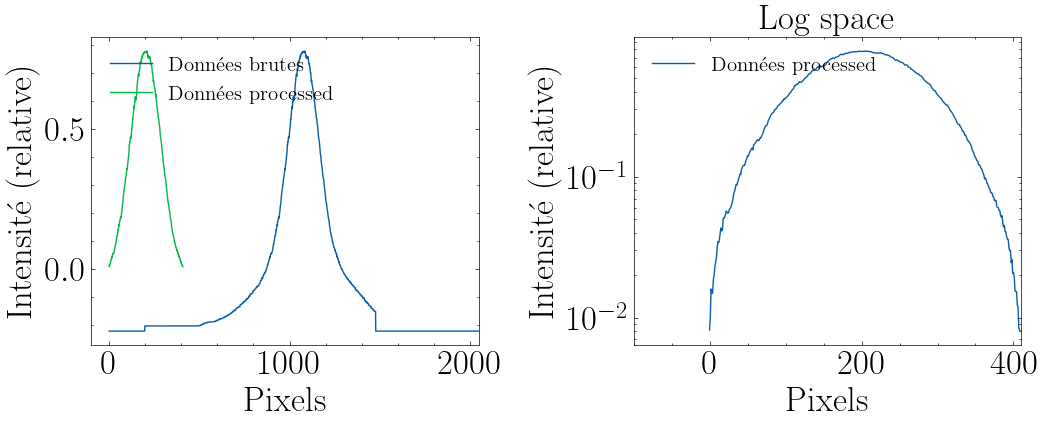

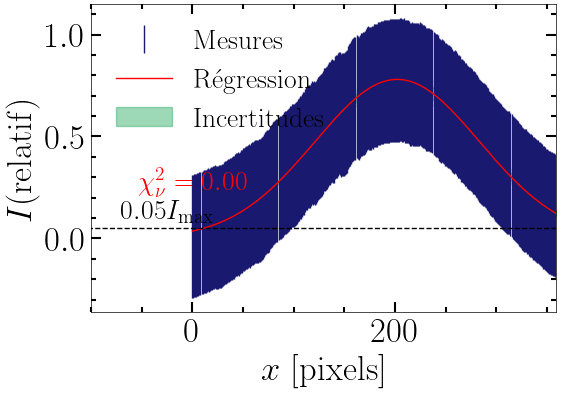

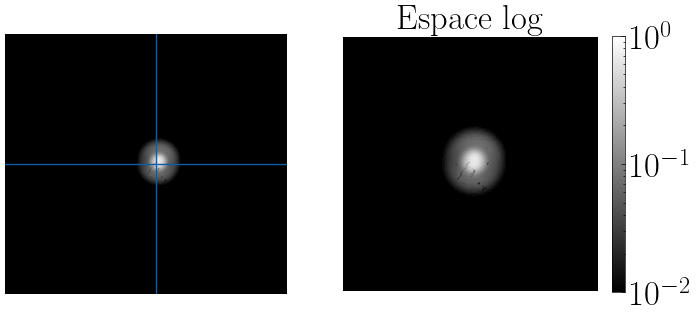

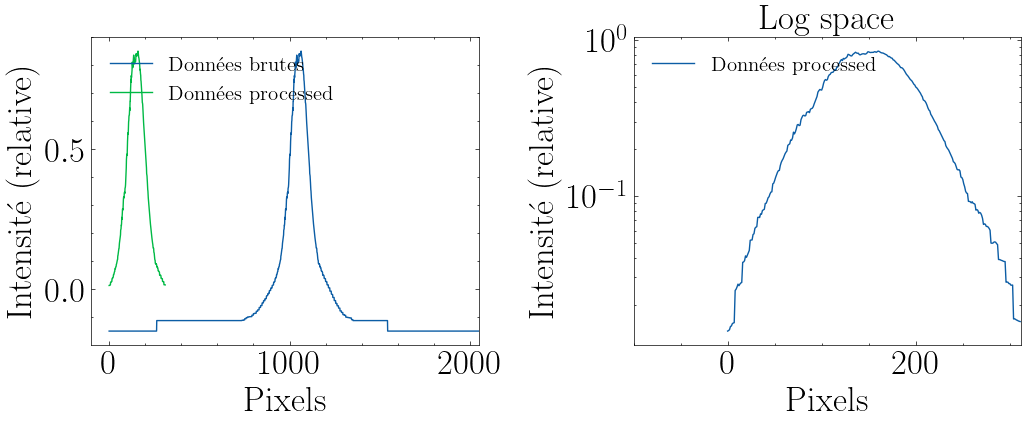

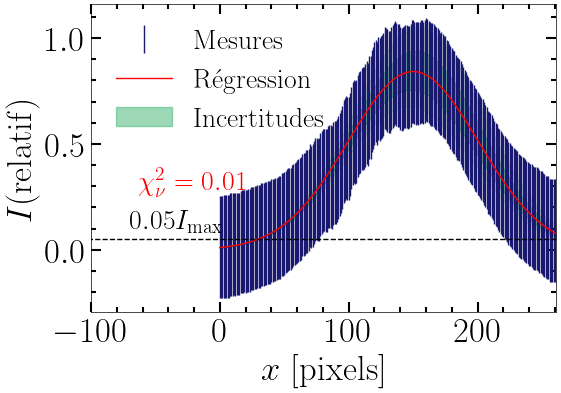

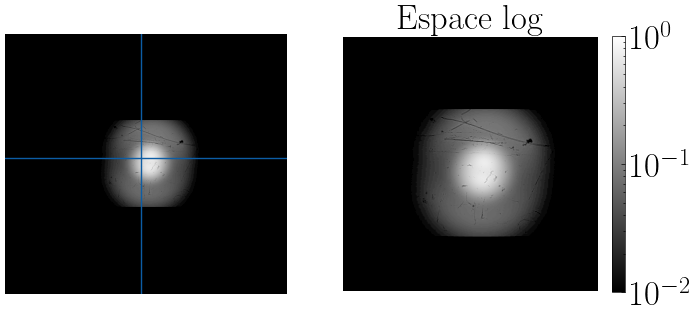

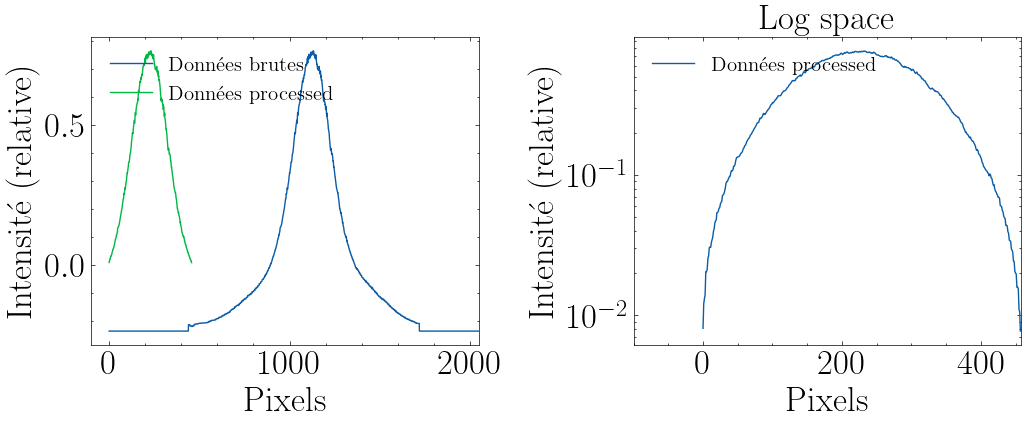

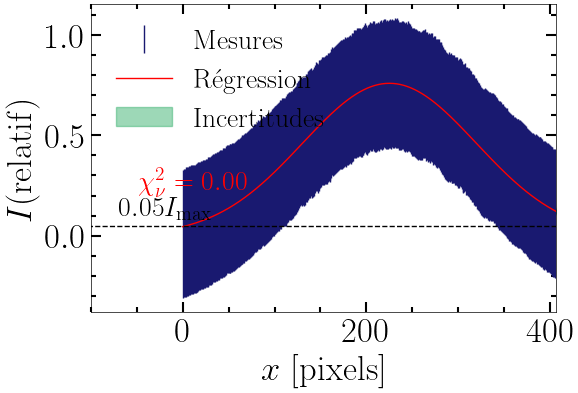

In [517]:
from glob import glob

pattern = figure_folder + "3a_blue_*_mode1.jpg"
paths = glob(pattern)

# R, std_R, d, std_d = analyze_data(paths[4], extent = 50, sanity_plots = True, padding = 1024, img_size = 1024)
R_bleu, std_r_bleu, d_bleu, std_d_bleu = [], [], [], []
extents = [1300, 1300, 1300, 1300, 1300] # on pourrait fine-tune pour avoir les meilleurs chi squared mais bon.
img_sizes = [2048, 2048, 2048, 2048, 2048]
for i, path in enumerate(paths):
    data = analyze_data(path, extent = extents[i], sanity_plots = True, padding = 1024, img_size = img_sizes[i], save = True)
    R_bleu.append(data[0])
    std_r_bleu.append(data[1])
    d_bleu.append(data[2])
    std_d_bleu.append(data[3])
R_bleu, std_r_bleu, d_bleu, std_d_bleu = np.array(R_bleu), np.array(std_r_bleu), np.array(d_bleu), np.array(std_d_bleu)

()
0.05763108170645088 0.09333933336587513


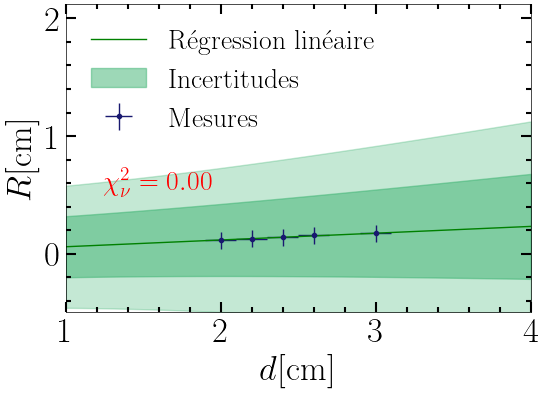

In [518]:
na_bleu, std_na_bleu = monomode_na(
    R = R_bleu, 
    d = d_bleu, 
    std_r = std_r_bleu.mean(), 
    std_d = std_d_bleu.mean(),
    sanity_plots = True,
    save = True,
    filename = "3a_blue"
)
print(na_bleu, std_na_bleu)

In [540]:
from glob import glob

pattern = figure_folder + "3a_green_*_mode1.jpg"
paths = glob(pattern)

# R, std_R, d, std_d = analyze_data(paths[4], extent = 50, sanity_plots = True, padding = 1024, img_size = 1024)
R_vert, std_r_vert, d_vert, std_d_vert = [], [], [], []
extents = [800, 800, 800, 800, 200] # on pourrait fine-tune pour avoir les meilleurs chi squared mais bon.
img_sizes = [1024, 1024, 2048, 2048, 1024]
for i, path in enumerate(paths):
    data = analyze_data(path, extent = extents[i], sanity_plots = False, padding = 1024, img_size = img_sizes[i], save = True)
    R_vert.append(data[0])
    std_r_vert.append(data[1])
    d_vert.append(data[2])
    std_d_vert.append(data[3])
R_vert, std_r_vert, d_vert, std_d_vert = np.array(R_vert), np.array(std_r_vert), np.array(d_vert), np.array(std_d_vert)

Processing file with d=0.02 meters
Fitting the Gaussian regression
chi 0.005329549278690945
0.0008996000000000001
Processing file with d=0.02 meters
Fitting the Gaussian regression
chi 0.004693817907787884
0.0009048
Processing file with d=0.03 meters
Fitting the Gaussian regression
chi 0.13544492990339785
0.0021892
Processing file with d=0.03 meters


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\2489117340.py:10: UserWarning: Le paramètre extent choisi est possiblement trop grand, attention...
  warnings.warn("Le paramètre extent choisi est possiblement trop grand, attention...")


Fitting the Gaussian regression
chi 0.030512027949690365
0.002444
Processing file with d=0.02 meters
Fitting the Gaussian regression
chi 1.3710193060957634
0.0013156


In [538]:
print(std_r_vert)

[0.        0.        0.0043576 0.        0.0026156]


In [544]:
na_vert, std_na_vert = monomode_na(
    R = R_vert, 
    d = d_vert, 
    std_r = std_r_vert.mean(), 
    std_d = std_d_vert.mean(),
    sanity_plots = False,
    save = True,
    filename = "3b_green"
)
print(na_vert, std_na_vert)

0.16737336113641585 0.1839226756045742


### Bonus 

On va essayer de créer un modèle physique pour les modes LP_lm. On veut que ce modèle soit assez flexible pour inclure des rotations et translations dans l'espace afin de pouvoir fitter une image des fibres monomodes. On fait l'implémentation avec PyTorch afin de pouvoir utiliser les bénéfices de l'autodifférentiation qui vont nous permettre de maximiser le NLL  (negaitve log-likelihood). Allons-y :). 


Pour garder les idées claires, notre modèle physique devrait prendre en entrée un tableau de valeurs dont: 
- Position $(x,y)$ définissant le centre du mode dans le plan 2D.
- Angle de rotation $\theta$ dans le plan 2D
- Rayon du coeur afin d'ajuster la taille du patron (déja inclus dans les modes) 
- Paramètre d'intensité maximale $f$ (qui pourrait être remplacé par un paramètre de flux)
- coefficients $\omega_i$ des 5 premiers modes $LP_{01}$, $LP_{11}$, $LP_{21}$, $LP_{02}$, $LP_{12}$ de telles sorte qu'on devrait pouvoir écrire la distribution d'intensité f comme 
$$
\begin{align}
g(r, \phi, \theta) = f\sum_{i=1}^{5}\omega_i \text{mode}_i(r, \phi, \theta) 
\end{align}
$$
où le $\theta$ apparaît dans les modes pour tenir en compte de la rotation. 

In [581]:
zeros_jv = np.array([jn_zeros(0, 1)[0], jn_zeros(1, 1)[0], jn_zeros(2, 1)[0], jn_zeros(0, 2)[1], jn_zeros(1, 2)[1]])

In [579]:
roots = jn_zeros(0, 2) 

In [580]:
roots

array([2.40482556, 5.52007811])

Text(0, 0.5, 'y')

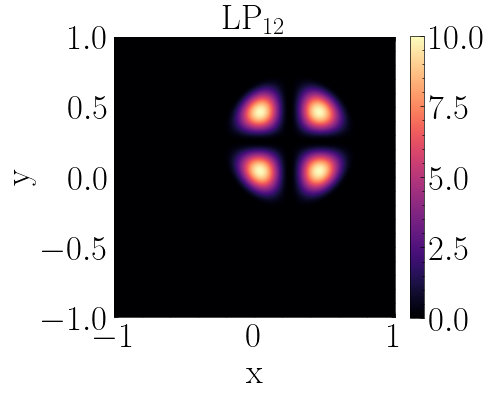

In [623]:
grid_size = 512 
r_max = 0.5 # micro mètres  
extent = 2 * r_max
x = np.linspace(-extent, extent, grid_size)
y = np.linspace(-extent, extent, grid_size)
X, Y = np.meshgrid(x, y)



def lp_mode(l, m, X, Y, theta, r_max, f = 1, center = (0, 0)):
    x_0, y_0 = center
    X_prime = (X - x_0) * np.cos(theta) + (Y - y_0) * np.sin(theta)
    Y_prime = -(X - x_0) * np.sin(theta) + (Y - y_0) * np.cos(theta) 
    R = np.sqrt(X_prime**2 + Y_prime**2)
    PHI = np.arctan2(Y_prime, X_prime)
    roots = jn_zeros(l, m) 
    u_lm = roots[m-1]  # m-1 à cause du zero-indexing
    intensity = np.abs(jv(l, u_lm * R / r_max) * np.cos(l * PHI) ) ** 2 
    f_norm = intensity.max()
    return (f/f_norm) * intensity *  (R<r_max)# la dernière multiplication mets à 0 les rayons supérieures au rayon de coeur. 

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

theta = np.pi / 4
l, m = 1, 2
f = 10
center = (0.25, 0.25)
intensity = lp_mode(2, 1, X, Y, theta, r_max, f, center)

norm = LogNorm(vmin = 1e-3, vmax =intensity.max(), clip = True)
norm = None
im = ax.imshow(intensity, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='magma')
plt.colorbar(im, fraction = 0.0455)
ax.set_title(r"$\mathrm{LP}_{%d %d}$"%(l,m))
ax.set_xlabel('x')
ax.set_ylabel('y')

# plt.savefig("LP_lm_modes.pdf", bbox_inches = 'tight')


Créons maintenant un modèle physique en numpy qui va prendre en input: 
$$
(x,y, r, e, \theta, f, \boldsymbol{\omega})
$$
positions, rayon, range, flux, coefficients.

In [582]:
zeros_jv = np.array([jn_zeros(0, 1)[0], jn_zeros(1, 1)[0], jn_zeros(2, 1)[0], jn_zeros(0, 2)[1], jn_zeros(1, 2)[1]])
ls = np.array([0, 1, 2, 0, 1])

In [ ]:
jn_zeros

In [701]:

def lp_mode(l, m, X, Y, theta, r_max, f = 1, center = (0, 0)):
    x_0, y_0 = center
    X_prime = (X - x_0) * np.cos(theta) + (Y - y_0) * np.sin(theta)
    Y_prime = -(X - x_0) * np.sin(theta) + (Y - y_0) * np.cos(theta) 
    R = np.sqrt(X_prime**2 + Y_prime**2)
    PHI = np.arctan2(Y_prime, X_prime)
    roots = jn_zeros(l, m) 
    u_lm = roots[m-1]  # m-1 à cause du zero-indexing
    print(f"first model, {u_lm}, {l}")
    # return jv(l, u_lm * R / r_max)
    # return np.cos(l*PHI)
    amplitude = jv(l, u_lm * R / r_max) * np.cos(l * PHI)
    # return amplitude
    intensity = np.abs(amplitude ) ** 2 
    f_norm = intensity.max()
    return (f/f_norm) * intensity *  (R<r_max)# la dernière multiplication mets à 0 les rayons supérieures au rayon de coeur. 

def model(params, grid_size=256): 
    x_0, y_0, r_max, extent, theta, f = params[:-5]
    omegas = params[-5:]
    x = np.linspace(-extent, extent, grid_size)
    y = np.linspace(-extent, extent, grid_size)
    X, Y = np.meshgrid(x, y)
    X_prime = (X - x_0) * np.cos(theta) + (Y - y_0) * np.sin(theta)
    Y_prime = -(X - x_0) * np.sin(theta) + (Y - y_0) * np.cos(theta) 
    R = np.sqrt(X_prime**2 + Y_prime**2)
    PHI = np.arctan2(Y_prime, X_prime)

    amplitude = 0 
    for i in range(5):
        u_lm = zeros_jv[i]
        l = ls[i]
        amplitude += omegas[i] * jv(l,  u_lm * R / r_max) * np.cos(l * PHI)

    intensity = np.abs(amplitude) ** 2 
    f_norm = intensity.max()
        
    return (f/f_norm) * intensity *  (R<r_max)

first model, 2.4048255576957724, 0


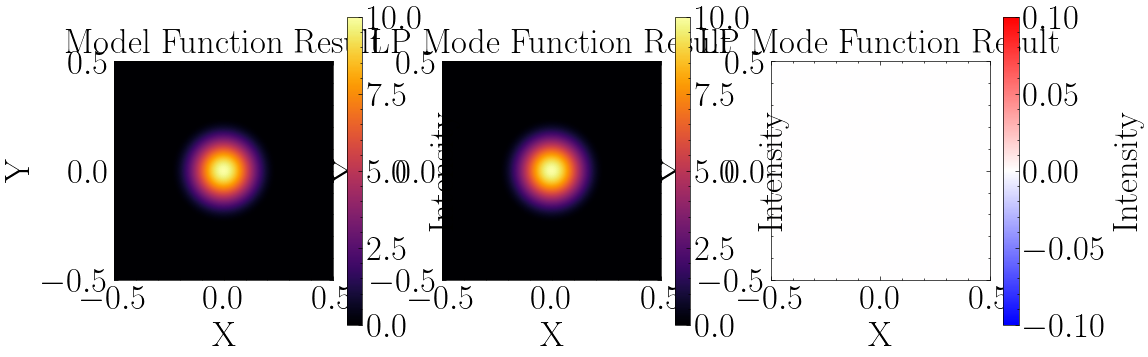

In [702]:


# Call the functions
center =np.array([0., 0.])
r_max = np.array([0.5])
extent = 2 * r_max
theta = np.array([np.pi/4])
f = np.array([10])
omegas = np.array([1.,0.,0,0.,0.]) # keeping the second mode 
params = np.concatenate([center, r_max, extent, theta, f, omegas])
grid_size = 512
x = np.linspace(-2*r_max, 2*r_max, grid_size)
y = np.linspace(-2*r_max, 2*r_max, grid_size)
X, Y = np.meshgrid(x, y)
result_model = model(params, grid_size)
result_lp_mode = lp_mode(0, 1, X, Y, theta = theta, r_max = r_max, f = f)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Model plot
c1 = axs[0].imshow(result_model, extent=(-extent/2, extent/2, -extent/2, extent/2), origin='lower', cmap='inferno')
axs[0].set_title('Model Function Result')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
plt.colorbar(c1, ax=axs[0], label='Intensity')

# LP Mode plot
c2 = axs[1].imshow(result_lp_mode, extent=(-extent/2, extent/2, -extent/2, extent/2), origin='lower', cmap='inferno')
axs[1].set_title('LP Mode Function Result')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
plt.colorbar(c2, ax=axs[1], label='Intensity')


# LP Mode plot
c2 = axs[2].imshow(result_lp_mode-result_model, extent=(-extent/2, extent/2, -extent/2, extent/2), origin='lower', cmap='bwr')
axs[2].set_title('LP Mode Function Result')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
plt.colorbar(c2, ax=axs[2], label='Intensity')

Text(0, 0.5, 'y')

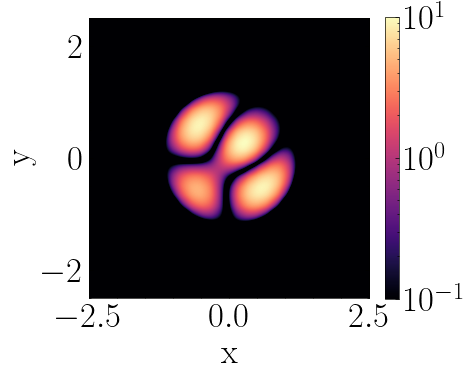

In [737]:
center =np.array([0., 0.])
r_max = np.array([0.5])
extent = 2 * r_max
theta = np.array([np.pi/4])
f = np.array([10])
omegas = np.array([0.1,2,0.2,1.,0.2]) # keeping the second mode 
omegas = np.array([0.1,0.1,3,1.,1]) # keeping the second mode 
# omegas = np.array([0., 0, 0, 1, 0]) # keeping the second mode 

# omegas = np.array([0.0, 1.0, 0.2, 0.3, 0.5]) 
# omegas = np.array([0.2, 0.5, 0.1, 0.5, 1.])   
params = np.concatenate([center, r_max, extent, theta, f, omegas])

grid_size = 512
intensity = model(params)

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
norm = LogNorm(vmin = 1e-1, vmax = 1e1, clip = True)
im = ax.imshow(intensity, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='magma', norm = norm)
plt.colorbar(im, fraction = 0.0455)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [704]:
# Example parameters
params = np.concatenate([np.array([0.5, 0.1]),  # center
                         np.array([0.5]),  # r_max
                         np.array([2.5]),  # extent
                         np.array([np.pi / 4]),  # theta
                         np.array([1]),  # f
                         np.array([1, 0, 0, 0, 0])])  # omegas

# Create a grid for testing
grid_size = 256
x = np.linspace(-2.5, 2.5, grid_size)
y = np.linspace(-2.5, 2.5, grid_size)
X, Y = np.meshgrid(x, y)

# Call the functions
result_model = model(params, grid_size)
result_lp_mode = lp_mode(1, 1, X, Y, np.pi / 4, 0.5)

# Compare the results
print("Model Result Max:", np.max(result_model))
print("LP Mode Result Max:", np.max(result_lp_mode))


first model, 3.8317059702075125, 1
Model Result Max: 0.9999999999999999
LP Mode Result Max: 1.0


In [698]:
!pip install imageio

In [738]:
import imageio


filenames = []

num_frames = 200
num_omegas = 5  

omegas_start = np.array([1., 0., 0., 0., 0.])
omegas_middle =  np.array([0.1,0.1,3,1.,1]) 
omegas_end = np.array([0.2, 0.5, 0.1, 0.5, 1.])
omegas_final = np.array([0., 0., 0., 1., 0.])           

# Itération sur les frames
for t in np.linspace(0, 1, num_frames):
    omegas = np.zeros(num_omegas)
    if t < 0.33:
        omegas = (1 - t * 3) * omegas_start + (t * 3) * omegas_middle
    elif t < 0.67:
        omegas = (1 - (t - 0.33) * 3) * omegas_middle + ((t - 0.33) * 3) * omegas_end
    else:
        omegas = (1 - (t - 0.67) * 3) * omegas_end + ((t - 0.67) * 3) * omegas_final
    params = np.concatenate([center, r_max, extent, theta, f, omegas])
    intensity = model(params, grid_size)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    norm = LogNorm(vmin = 1e-1, vmax = 1e1, clip = True)
    im = ax.imshow(intensity, extent=(-extent, extent, -extent, extent), origin='lower', cmap='magma', norm = norm)
    plt.colorbar(im, fraction=0.0455)
    
    filename = f'temp_frame_mode_t{t:.2f}.jpeg'
    plt.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# Faire GIF
with imageio.get_writer('omegas_interpolation.gif', mode='I', duration=0.5, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


C:\Users\noedi\AppData\Local\Temp\ipykernel_15776\3300162853.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable: 'temp_frame_mode_t0.01.jpeg'

Parfait, on peut maintenant implémenter ça en torch.

0.7853981633974483